In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os
import json
import cv2
import numpy as np
import time
from progress.bar import Bar
import torch
import copy
import xlrd
from libtiff import TIFF

from opts import opts
from config1 import config as config1
from config_new_1 import config
from logger import Logger

from utils.utils import AverageMeter
from dataset.dataset_factory import dataset_factory,get_dataset
from detector1 import Detector as Detector1
from detector import Detector
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

/cis/home/lhuang/anaconda3/envs/CenterTrackENV/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [4]:
opt=config()
opt.init()
opt1=config1()
opt1.init()

Running tracking
Using tracking threshold for out threshold! 0.7
Fix size testing.
training chunk_sizes: [8, 8]
input h w: 512 512
heads {'hm': 2, 'reg': 2, 'wh': 2, 'tracking': 2}
weights {'hm': 2.0, 'reg': 1.0, 'wh': 0.4, 'tracking': 1.0}
head conv {'hm': [256], 'reg': [256], 'wh': [256], 'tracking': [256]}
Running tracking
Using tracking threshold for out threshold! 0.35
Fix size testing.
training chunk_sizes: [16]
input h w: 512 512
heads {'hm': 2, 'reg': 2, 'wh': 2, 'tracking': 2}
weights {'hm': 2.0, 'reg': 1.0, 'wh': 0.4, 'tracking': 1.0}
head conv {'hm': [256], 'reg': [256], 'wh': [256], 'tracking': [256]}


In [14]:
class PrefetchDataset_new(torch.utils.data.Dataset):
    def __init__(self, opt, pre_process_func,stable=False,from_video=True,dataset=None):
        if dataset != None:
            self.images = dataset.images
            self.load_image_func = dataset.coco.loadImgs
            self.get_default_calib = dataset.get_default_calib
        #self.roi_center=[316,609]
        self.roi_center=[]
        #self.roi_center=[300,568]
        self.crop_size=[512,512]
        self.img_dir = os.path.join(opt.data_dir,'CellTracking')
        self.video_dir=os.path.join(self.img_dir,'train_new_1','Video')
        #self.img_dir=os.path.join(opt.data_dir,'CellTracking','train','Video_001','image','1.jpg')
        self.ann_dir=self.img_dir.replace('image','cellLabel.xlsx')
        self.from_video=from_video
        if self.from_video:
            self.init_video()
            if stable:
                self.images = self.stabilize_video(self.images)
                if len(self.roi_center)==0:
                    self.roi_center=self.select_roi(self.images)
            else:
                print('Pre-selected ROI: ',self.roi_center)
        self.pre_process_func = pre_process_func
        self.opt = opt
    def __getitem__(self, index):
        img_id = index % len(self.images)
        center=self.roi_center
        w,h=int(self.crop_size[0]/2),int(self.crop_size[1]/2)
        if not self.from_video:
            img_info = self.load_image_func(ids=[img_id])[0]
            img_path = os.path.join(self.img_dir, img_info['file_name'])
            image= cv2.imread(img_path)
        else:
            img = self.images[index].astype(np.float32)[center[0]-h:center[0]+h,center[1]-w:center[1]+w]
            img = img - np.min(img)
            img = img / np.max(img)
            clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
            #equ = cv2.equalizeHist(image)
            img = clahe.apply(np.uint8(img*255.0))
            img=Image.fromarray(img).convert('RGB')
            img.save('s.jpg')
            image = cv2.imread('s.jpg')
        images, meta = {}, {}
        for scale in opt.test_scales:
            input_meta = {}
            calib = self.get_default_calib(image.shape[1], image.shape[0])
            input_meta['calib'] = calib
            images[scale], meta[scale] = self.pre_process_func(image, scale, input_meta)
        ret = {'images': images, 'image': image, 'meta': meta}
        if img_id == 0:
            ret['is_first_frame'] = 1
        ret['video_id'] = 1
        return img_id, ret    
    def init_video(self):
        video_path=os.listdir(self.video_dir)
        video_path=[p for p in video_path if '.tif' in p]
        video_path.sort()
        print(video_path)
        video_path=video_path[2]
        print('Reading video from: ',video_path)
        self.video_path=os.path.join(self.video_dir,video_path)
        tif = TIFF.open(self.video_path)
        self.images=list(tif.iter_images())
        print(len(self.images))
    def __len__(self):
        return len(self.images)
    
    def flow_estimation(self):
        return np.sum(self.images)
    
    def move_estimate_video(self,video):
        n_frame=len(video)
        transforms = np.zeros((n_frame-1, 3), np.float32)
        prev_gray = np.float32(video[0])
        prev_gray -= np.min(prev_gray)
        prev_gray /= np.max(prev_gray)
        prev_gray = np.uint8(prev_gray*255)
        h,w=prev_gray.shape
        video_out=np.zeros((n_frame,h,w))
        video_out[0]=prev_gray
        for i in range(1,n_frame):
            prev_pts = cv2.goodFeaturesToTrack(prev_gray[:,-300:],
                                             maxCorners=200,
                                             qualityLevel=0.01,
                                             minDistance=50,
                                             blockSize=40)
            #curr_gray = np.hstack([video[i][:,:75],video[i][:,-75:]])
            curr_gray = np.float32(video[i])
            curr_gray -= np.min(curr_gray)
            curr_gray /= np.max(curr_gray)
            curr_gray = np.uint8(curr_gray*255)
            video_out[i]=curr_gray
            curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray[:,-300:], curr_gray[:,-300:], prev_pts, None)

            # Sanity check
            assert prev_pts.shape == curr_pts.shape

            # Filter only valid points
            idx = np.where(status==1)[0]
            prev_pts = prev_pts[idx]
            curr_pts = curr_pts[idx]

            #Find transformation matrix
            m,inliers = cv2.estimateAffinePartial2D(prev_pts, curr_pts)
            # Extract translation
            dx = m[0,2]
            dy = m[1,2]

            # Extract rotation angle
            da = np.arctan2(m[1,0], m[0,0])

            # Store transformation
            transforms[i-1] = [dx,dy,da]

            # Move to next frame
            prev_gray = curr_gray
        return transforms,video_out
    
    def stabilize_video(self,video):
        print('Stabilizing Video...')
        start_time=time.time()
        transforms,video=self.move_estimate_video(video)
        transforms  = -np.cumsum(transforms, axis=0)
        n_frames=len(video)
        h,w = video[0].shape
        # Reset stream to first frame
        frames_out=np.zeros([n_frames,h,w])
        frames_out[0]=video[0]
        # Write n_frames-1 transformed frames
        for i in range(1,n_frames):
            # Read next frame
            frame = video[i]
            # Extract transformations from the new transformation array
            dx = transforms[i-1,0]
            dy = transforms[i-1,1]
            da = transforms[i-1,2]
            # Reconstruct transformation matrix accordingly to new values
            m = np.zeros((2,3), np.float32)
            m[0,0] = np.cos(da)
            m[0,1] = -np.sin(da)
            m[1,0] = np.sin(da)
            m[1,1] = np.cos(da)
            m[0,2] = dx
            m[1,2] = dy
            # Apply affine wrapping to the given frame
            frame_stabilized = cv2.warpAffine(frame, m, (w,h))
            # Fix border artifacts
            frame_stabilized = fixBorder(frame_stabilized)
            frames_out[i] = frame_stabilized
        end_time=time.time()
        print('Video Stabilization Done!')
        print('stabilization time:', end_time-start_time)
        return frames_out
    def select_roi(self,video):
        print('Selecting ROI...')
        start_time=time.time()
        diff=np.zeros_like(video[0])
        for i in range(1,len(video),50):
            diff += np.abs(video[i]-video[i-1])
        diff[:10,:]=0
        diff[-10:,:]=0
        diff[:,:10]=0
        diff[:,-10:]=0
        from scipy import signal
        kernel1=np.ones((64,64))
        conved=signal.convolve2d(diff, kernel1, 'valid')
        x,y=np.unravel_index(np.argmax(conved, axis=None), conved.shape)
        end_time=time.time()
        print('Selected ROI: ',[x,y])
        print('Selection time:', end_time-start_time)
        return [x,y]
                         
def fixBorder(frame):
    s = frame.shape
    # Scale the image 4% without moving the center
    T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.04)
    frame = cv2.warpAffine(frame, T, (s[1], s[0]))
    return frame
def _to_list(results):
    for img_id in results:
        for t in range(len(results[img_id])):
            for k in results[img_id][t]:
                if isinstance(results[img_id][t][k], (np.ndarray, np.float32)):
                    results[img_id][t][k] = results[img_id][t][k].tolist()
    return results

In [15]:
Dataset = dataset_factory[opt.test_dataset]
detector = Detector1(opt)
dataset = Dataset(opt, 'train_new_1')
dataset_sample=PrefetchDataset_new(opt, detector.pre_process,stable=True,dataset=dataset)

Creating model...
Using node type: (<class 'model.networks.dla.DeformConv'>, <class 'model.networks.dla.DeformConv'>)
loaded /cis/home/lhuang/my_documents/Cytometry/CenterTrack/exp/tracking/cell_tracking1/logs_2020-09-27-15-13/model_300.pth, epoch 300
Drop parameter base.fc.weight.
Drop parameter base.fc.bias.
==> initializing train_new_1 data from /cis/home/lhuang/my_documents/Cytometry/CenterTrack/data/CellTracking/train_new_1/celldata.json, 
 images from /cis/home/lhuang/my_documents/Cytometry/CenterTrack/data/CellTracking ...
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Creating video index!
Loaded CellTrack train_new_1 355 samples
['256_GFC_505nm_40X1p15NA_PCO_500usexp_160fps_10.tif', '256_GFC_505nm_40X1p15NA_PCO_500usexp_160fps_10@0001.tif', '256_GFC_505nm_40X1p15NA_PCO_500usexp_160fps_3.tif', '256_GFC_505nm_40X1p15NA_PCO_500usexp_160fps_3@0001.tif', '256_GFC_505nm_40X1p15NA_PCO_500usexp_160fps_4.tif', '256_GFC_505nm_40X1p15NA_PCO_500usexp_16

In [49]:
for num in range(720,730):
    _,img=dataset_sample[num]
    img=img['image']
    print(img.shape)
    img=Image.fromarray(img).convert('RGB')
    img.save('demo{}.jpg'.format(num))
    #plt.imshow(image['image'])
    #plt.show()
#print(dataset_sample.video_path.split('.')[0].split('_')[-1])

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


In [17]:
if not opt.not_set_cuda_env:
    os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
Dataset = dataset_factory[opt.test_dataset]
#opt = config().update_dataset_info_and_set_heads(opt, Dataset)
print(opt)
#Logger(opt)

#split = 'val' if not opt.trainval else 'test'
dataset = Dataset(opt, 'train_new_1')
#opt1.tracking_base=False
#detector1=Detector(opt1)
opt.tracking_base=True
detector = Detector1(opt)
#detector1 = Detector(opt)
if opt.load_results != '':
    load_results = json.load(open(opt.load_results, 'r'))
    for img_id in load_results:
        for k in range(len(load_results[img_id])):
            if load_results[img_id][k]['class'] - 1 in opt.ignore_loaded_cats:
                load_results[img_id][k]['score'] = -1
else:
    load_results = {}
'''
data_loader = torch.utils.data.DataLoader(
    PrefetchDataset(opt, dataset, detector.pre_process), 
    batch_size=1, shuffle=False, num_workers=1, pin_memory=True)
'''
#datas=PrefetchDataset_new(opt, detector.pre_process,stable=True,dataset=dataset)
data_loader = torch.utils.data.DataLoader(
    PrefetchDataset_new(opt, detector.pre_process,stable=True,dataset=dataset), batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

results = {}
results1 = {}
start_iters = 0
num_iters = len(data_loader) if opt.num_iters < 0 else opt.num_iters
num_iters = min(num_iters,1000)
bar = Bar('{}'.format(opt.exp_id), max=num_iters)
time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge', 'track']
avg_time_stats = {t: AverageMeter() for t in time_stats}
vis=[]
vis1=[]
vel=[]
if opt.use_loaded_results:
    for img_id in data_loader.dataset.images:
        results[img_id] = load_results['{}'.format(img_id)]
    num_iters = 0
for ind, (img_id, pre_processed_images) in enumerate(data_loader):
    #plt.imshow(pre_processed_images['image'][0])
    #plt.show()
    if ind < start_iters:
        continue
    if ind >= num_iters:
        break
    if opt.tracking and ('is_first_frame' in pre_processed_images):
        #plt.imshow(pre_processed_images['mask'])
        #plt.show()
        if '{}'.format(int(img_id.numpy().astype(np.int32)[0])) in load_results:
            pre_processed_images['meta']['pre_dets'] = \
              load_results['{}'.format(int(img_id.numpy().astype(np.int32)[0]))]
        else:
            print()
            print('No pre_dets for', int(img_id.numpy().astype(np.int32)[0]), 
              '. Use empty initialization.')
            pre_processed_images['meta']['pre_dets'] = []
        detector.reset_tracking()
        #detector1.reset_tracking()
        print('Start tracking video', int(pre_processed_images['video_id']))
    if opt.public_det:
        if '{}'.format(int(img_id.numpy().astype(np.int32)[0])) in load_results:
            pre_processed_images['meta']['cur_dets'] = \
              load_results['{}'.format(int(img_id.numpy().astype(np.int32)[0]))]
        else:
            print('No cur_dets for', int(img_id.numpy().astype(np.int32)[0]))
            pre_processed_images['meta']['cur_dets'] = []
    ret = detector.run(pre_processed_images)
    #ret1= detector1.run(pre_processed_images)
    results[int(img_id.numpy().astype(np.int32)[0])] = ret['results']
    #results1[int(img_id.numpy().astype(np.int32)[0])] = ret1['results']
    vel.append(ret['velocity'])
    vis.append(ret['generic'])
    #vis1.append(ret1['generic'])
    Bar.suffix = '[{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(
                   ind, num_iters, total=bar.elapsed_td, eta=bar.eta_td)
    for t in avg_time_stats:
        avg_time_stats[t].update(ret[t])
        Bar.suffix = Bar.suffix + '|{} {tm.val:.3f}s ({tm.avg:.3f}s) '.format(
            t, tm = avg_time_stats[t])
    if opt.print_iter > 0:
        if ind % opt.print_iter == 0:
            print('{}/{}| {}'.format(opt.task, opt.exp_id, Bar.suffix))
    else:
          bar.next()
bar.finish()

==> initializing train_new_1 data from /cis/home/lhuang/my_documents/Cytometry/CenterTrack/data/CellTracking/train_new_1/celldata.json, 
 images from /cis/home/lhuang/my_documents/Cytometry/CenterTrack/data/CellTracking ...
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Creating video index!
Loaded CellTrack train_new_1 355 samples
Creating model...
Using node type: (<class 'model.networks.dla.DeformConv'>, <class 'model.networks.dla.DeformConv'>)
loaded /cis/home/lhuang/my_documents/Cytometry/CenterTrack/exp/tracking/cell_tracking1/logs_2020-09-27-15-13/model_300.pth, epoch 300
Drop parameter base.fc.weight.
Drop parameter base.fc.bias.
['256_GFC_505nm_40X1p15NA_PCO_500usexp_160fps_10.tif', '256_GFC_505nm_40X1p15NA_PCO_500usexp_160fps_10@0001.tif', '256_GFC_505nm_40X1p15NA_PCO_500usexp_160fps_3.tif', '256_GFC_505nm_40X1p15NA_PCO_500usexp_160fps_3@0001.tif', '256_GFC_505nm_40X1p15NA_PCO_500usexp_160fps_4.tif', '256_GFC_505nm_40X1p15NA_PCO_500usexp_16

********************
[-11.464371    6.6562676]
********************
[[212.80683899 227.63049316 259.31652832 264.23123169  12.        ]
 [257.09527588 237.80151367 290.31164551 293.45788574   3.        ]
 [233.58062744 254.9564209  266.86779785 296.22497559  10.        ]
 [278.04016113 218.94142151 305.7177124  263.70947266  13.        ]
 [287.46246338 206.89654541 318.42871094 250.77471924  11.        ]
 [209.71768188 256.01950073 238.26638794 299.09542847  14.        ]
 [302.97909546 197.96710205 330.84976196 245.04397583  15.        ]]
tracking/cell_tracking1| [9/1000]|Tot: 0:00:03 |ETA: 0:00:00 |tot 0.064s (0.092s) |load 0.000s (0.000s) |pre 0.003s (0.005s) |net 0.017s (0.026s) |dec 0.002s (0.003s) |post 0.000s (0.001s) |merge 0.036s (0.050s) |track 0.006s (0.008s) 
********************
[-8.251612  8.177267]
********************
[[215.3669281  222.06138611 267.54595947 253.19929504  12.        ]
 [281.14749146 213.04699707 316.06069946 254.36288452  13.        ]
 [247.39912415 247.

tracking/cell_tracking1| [21/1000]|Tot: 0:00:06 |ETA: 0:00:00 |tot 0.108s (0.086s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.026s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.001s) |merge 0.066s (0.048s) |track 0.009s (0.008s) 
********************
[-11.819458    6.8834915]
********************
[[310.29760742 213.8943634  341.48956299 260.53265381  28.        ]
 [273.6690979  201.45811462 323.04232788 235.71009827  26.        ]
 [276.25100708 229.36012268 311.92526245 274.92086792  27.        ]
 [232.07363892 248.71563721 259.96572876 287.42529297  25.        ]]
tracking/cell_tracking1| [22/1000]|Tot: 0:00:06 |ETA: 0:00:00 |tot 0.075s (0.085s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.019s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.043s (0.048s) |track 0.008s (0.008s) 
********************
[-9.19137   8.829043]
********************
[[287.29129028 192.68460083 334.08218384 225.64025879  26.        ]
 [293.60818481 221.11224365 325.11245728 264.13870239

tracking/cell_tracking1| [34/1000]|Tot: 0:00:10 |ETA: 0:00:00 |tot 0.090s (0.084s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.019s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.057s (0.048s) |track 0.007s (0.008s) 
********************
[-9.374983   6.6468544]
********************
[[305.40014648 203.62399292 348.57922363 238.57699585  30.        ]
 [241.2315979  252.22169495 281.49447632 294.35638428  35.        ]
 [339.89358521 194.75410461 373.38796997 232.91169739  33.        ]
 [348.24645996 185.10887146 380.24224854 223.90467834  32.        ]
 [255.67953491 238.69651794 297.33126831 277.40722656  34.        ]
 [308.85809326 236.6885376  352.79754639 279.02893066  36.        ]
 [292.73187256 232.16897583 320.67279053 282.73922729  37.        ]
 [280.51754761 198.29847717 313.78518677 228.57585144  38.        ]]
tracking/cell_tracking1| [35/1000]|Tot: 0:00:10 |ETA: 0:00:00 |tot 0.073s (0.083s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.021s) |dec 

tracking/cell_tracking1| [46/1000]|Tot: 0:00:13 |ETA: 0:00:00 |tot 0.069s (0.084s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.040s (0.049s) |track 0.007s (0.008s) 
********************
[-15.574333  10.438385]
********************
[[311.2024231  195.39315796 365.02792358 224.22509766  46.        ]
 [291.6210022  225.34526062 327.54238892 274.41455078  44.        ]
 [358.32723999 207.04580688 379.93722534 248.59896851  40.        ]
 [236.37704468 387.34185791 279.1257019  416.21276855  47.        ]
 [308.12164307 229.78741455 342.3614502  277.55444336  48.        ]
 [182.04359436 230.67219543 219.15028381 268.49157715  49.        ]]
tracking/cell_tracking1| [47/1000]|Tot: 0:00:13 |ETA: 0:00:00 |tot 0.131s (0.085s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.043s (0.021s) |dec 0.005s (0.002s) |post 0.001s (0.000s) |merge 0.071s (0.049s) |track 0.009s (0.008s) 
********************
[-15.545941   9.283429]
******

tracking/cell_tracking1| [58/1000]|Tot: 0:00:16 |ETA: 0:00:00 |tot 0.063s (0.083s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.036s (0.048s) |track 0.005s (0.008s) 
********************
[-16.854492  15.188603]
********************
[[313.86361694 199.97651672 361.81399536 230.99766541  61.        ]
 [282.92614746 230.04705811 322.16534424 280.62896729  57.        ]
 [314.7467041  234.45979309 348.87506104 273.36608887  62.        ]]
tracking/cell_tracking1| [59/1000]|Tot: 0:00:16 |ETA: 0:00:00 |tot 0.091s (0.084s) |load 0.000s (0.000s) |pre 0.007s (0.004s) |net 0.026s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.049s (0.048s) |track 0.007s (0.008s) 
********************
[-9.849609 11.259651]
********************
[[329.36837769 191.30334473 370.37307739 217.84457397  62.        ]
 [361.80871582 199.22117615 384.95770264 242.95246887  63.        ]]
tracking/cell_tracking1| [60/1000]|Tot: 0:00:17 |ETA: 

********************
[-17.89544   17.337616]
********************
[[295.06463623 239.14518738 332.06756592 285.60287476  71.        ]
 [265.59204102 224.38461304 316.0894165  256.88778687  69.        ]
 [310.44866943 225.32505798 348.08209229 252.06382751  68.        ]
 [309.28543091 209.86865234 359.56039429 235.82281494  70.        ]
 [215.60839844 159.31433105 241.13464355 188.01428223  72.        ]]
tracking/cell_tracking1| [73/1000]|Tot: 0:00:20 |ETA: 0:00:00 |tot 0.076s (0.083s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.046s (0.048s) |track 0.008s (0.008s) 
********************
[-25.690577  20.80022 ]
********************
[[289.02301025 206.75759888 336.90795898 237.92581177  70.        ]
 [339.7124939  213.53405762 368.99484253 261.25595093  68.        ]
 [279.30355835 231.17718506 321.61251831 272.47189331  69.        ]
 [266.64382935 262.69573975 295.34078979 293.49041748  72.        ]
 [330.96020508 197

tracking/cell_tracking1| [85/1000]|Tot: 0:00:23 |ETA: 0:00:00 |tot 0.089s (0.084s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.021s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.052s (0.048s) |track 0.008s (0.008s) 
********************
[-19.910065  15.34433 ]
********************
[[310.11712646 221.87539673 342.98303223 270.85107422  79.        ]
 [338.00039673 189.76664734 382.47915649 232.03190613  68.        ]
 [330.0168457  210.30134583 359.87384033 264.10357666  82.        ]]
tracking/cell_tracking1| [86/1000]|Tot: 0:00:23 |ETA: 0:00:00 |tot 0.070s (0.083s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.041s (0.048s) |track 0.007s (0.008s) 
********************
[-20.471766  12.740293]
********************
[[331.66812134 208.59805298 364.76870728 249.69192505  82.        ]
 [315.82110596 218.40808105 351.11206055 269.23596191  79.        ]
 [354.81869507 199.02703857 386.48287964 247.63311768

tracking/cell_tracking1| [100/1000]|Tot: 0:00:27 |ETA: 0:00:00 |tot 0.061s (0.083s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.021s) |dec 0.002s (0.002s) |post 0.001s (0.000s) |merge 0.034s (0.048s) |track 0.006s (0.008s) 
********************
[-20.96225    9.469523]
********************
[[273.93103027 231.82579041 312.48364258 282.63000488  96.        ]
 [325.10510254 216.65888977 361.24224854 249.23271179  90.        ]
 [304.34503174 253.5428009  353.36755371 296.71557617  92.        ]]
tracking/cell_tracking1| [101/1000]|Tot: 0:00:27 |ETA: 0:00:00 |tot 0.080s (0.083s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.020s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.045s (0.048s) |track 0.008s (0.008s) 
********************
[-18.6697    14.306538]
********************
[[273.99981689 257.89001465 315.54144287 305.27709961  96.        ]
 [284.12670898 225.28100586 335.07922363 269.40893555  92.        ]
 [339.14648438 192.62910461 380.47698975 229.138839

tracking/cell_tracking1| [113/1000]|Tot: 0:00:30 |ETA: 0:00:00 |tot 0.071s (0.082s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.040s (0.048s) |track 0.009s (0.008s) 
********************
[-14.142415  11.753215]
********************
[[307.60803223 253.96038818 342.230896   295.17498779 102.        ]
 [336.75546265 212.99736023 376.41030884 247.97862244  97.        ]
 [324.57678223 229.60092163 362.78479004 276.55447388 100.        ]]
tracking/cell_tracking1| [114/1000]|Tot: 0:00:31 |ETA: 0:00:00 |tot 0.067s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.041s (0.048s) |track 0.004s (0.008s) 
********************
[-20.040543  10.009499]
********************
[[345.19342041 220.59899902 385.75170898 264.95376587  97.        ]
 [277.40859985 272.97122192 301.34072876 310.27578735 104.        ]]
tracking/cell_tracking1| [115/1000]|Tot: 0:00:31 |

tracking/cell_tracking1| [127/1000]|Tot: 0:00:34 |ETA: 0:00:00 |tot 0.077s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.048s (0.048s) |track 0.007s (0.008s) 
********************
[-16.716726   9.907969]
********************
[[265.28689575 251.76559448 325.15164185 284.85049438 114.        ]
 [276.2208252  286.36538696 325.45678711 321.32748413 113.        ]
 [312.5005188  251.00520325 362.10025024 284.51879883 112.        ]]
tracking/cell_tracking1| [128/1000]|Tot: 0:00:34 |ETA: 0:00:00 |tot 0.072s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.043s (0.048s) |track 0.007s (0.008s) 
********************
[-13.78891    8.520676]
********************
[[279.34899902 244.09855652 341.32061768 276.30078125 114.        ]
 [290.53009033 278.72305298 338.68267822 317.72634888 113.        ]
 [328.36294556 242.38084412 372.51773071 273.503753

tracking/cell_tracking1| [140/1000]|Tot: 0:00:38 |ETA: 0:00:00 |tot 0.089s (0.082s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.020s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.051s (0.048s) |track 0.009s (0.008s) 
********************
[-15.209021  11.825299]
********************
[[323.0887146  258.47903442 360.36050415 296.72970581 129.        ]
 [333.31982422 247.01867676 375.37188721 291.99224854 125.        ]
 [275.95568848 272.0166626  318.24151611 300.53015137 127.        ]
 [336.11334229 221.20509338 382.76593018 260.8949585  118.        ]
 [273.45727539 254.27886963 326.69616699 287.37365723 128.        ]
 [271.7036438  313.12414551 302.26431274 332.98413086 130.        ]
 [253.4029541  281.20220947 288.84741211 315.13220215 131.        ]]
tracking/cell_tracking1| [141/1000]|Tot: 0:00:38 |ETA: 0:00:00 |tot 0.082s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.050s (0.048s) |trac

tracking/cell_tracking1| [152/1000]|Tot: 0:00:41 |ETA: 0:00:00 |tot 0.089s (0.083s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.061s (0.049s) |track 0.007s (0.008s) 
********************
[-12.628962  11.590845]
********************
[[319.91226196 258.13250732 362.10256958 290.4463501  141.        ]
 [284.76516724 259.79510498 328.70767212 295.90179443 138.        ]
 [321.47973633 239.55644226 363.41778564 260.13809204 142.        ]
 [338.59320068 211.775177   386.24615479 236.4732666  143.        ]
 [296.9977417  274.49179077 328.96868896 327.39834595 144.        ]
 [250.53112793 291.7388916  290.53607178 341.94689941 145.        ]]
tracking/cell_tracking1| [153/1000]|Tot: 0:00:41 |ETA: 0:00:00 |tot 0.092s (0.083s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.021s (0.020s) |dec 0.003s (0.002s) |post 0.001s (0.000s) |merge 0.054s (0.049s) |track 0.010s (0.008s) 
********************
[-16.102219  15.236687]
****

********************
[-15.963264   10.3834915]
********************
[[241.4524231  313.12115479 279.47903442 352.09906006 151.        ]
 [278.90670776 298.77740479 321.60952759 343.27166748 153.        ]
 [353.98754883 278.99179077 382.38299561 323.74917603 152.        ]
 [356.54925537 249.24290466 406.9543457  287.08529663 155.        ]
 [305.1690979  310.07070923 341.36959839 348.38137817 156.        ]]
tracking/cell_tracking1| [166/1000]|Tot: 0:00:45 |ETA: 0:00:00 |tot 0.077s (0.083s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.018s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.047s (0.049s) |track 0.008s (0.008s) 
********************
[-13.826208   9.133453]
********************
[[331.86706543 258.99890137 376.85540771 302.33728027 155.        ]
 [322.76730347 296.30355835 357.87460327 340.56765747 156.        ]
 [258.73242188 304.93557739 302.73406982 341.53427124 153.        ]
 [367.51754761 270.09207153 386.37026978 309.60745239 152.        ]
 [367.80526733 

tracking/cell_tracking1| [178/1000]|Tot: 0:00:48 |ETA: 0:00:00 |tot 0.073s (0.083s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.042s (0.049s) |track 0.010s (0.008s) 
********************
[-18.528294  16.538227]
********************
[[304.72506714 265.25088501 346.88394165 307.70205688 158.        ]
 [369.74835205 249.44602966 395.2298584  287.78723145 168.        ]
 [145.22146606 369.61502075 186.80227661 401.48849487 169.        ]
 [224.10826111 308.45147705 275.37127686 336.39172363 170.        ]
 [279.91604614 299.57507324 325.06130981 342.56427002 171.        ]]
tracking/cell_tracking1| [179/1000]|Tot: 0:00:48 |ETA: 0:00:00 |tot 0.081s (0.083s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.047s (0.049s) |track 0.009s (0.008s) 
********************
[-22.160389  15.462652]
********************
[[223.06317139 316.0411377  260.34753418 356.003906

tracking/cell_tracking1| [191/1000]|Tot: 0:00:51 |ETA: 0:00:00 |tot 0.077s (0.083s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.019s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.042s (0.048s) |track 0.009s (0.008s) 
********************
[-11.897471  10.338104]
********************
[[316.0953064  280.234375   353.87869263 328.55474854 186.        ]
 [360.99343872 240.30895996 391.24685669 258.7277832  183.        ]
 [278.72793579 305.57165527 315.82693481 346.21899414 185.        ]
 [365.35644531 260.34017944 393.84637451 301.82443237 180.        ]
 [331.4574585  270.9836731  369.46697998 313.54336548 184.        ]
 [324.38217163 248.67481995 376.16622925 279.36160278 187.        ]]
tracking/cell_tracking1| [192/1000]|Tot: 0:00:52 |ETA: 0:00:00 |tot 0.089s (0.083s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.020s (0.020s) |dec 0.002s (0.002s) |post 0.001s (0.000s) |merge 0.053s (0.048s) |track 0.010s (0.008s) 
********************
[-18.284803  13.473521]
****

tracking/cell_tracking1| [204/1000]|Tot: 0:00:55 |ETA: 0:00:00 |tot 0.104s (0.083s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.070s (0.048s) |track 0.009s (0.008s) 
********************
[-2.5899549  8.035929 ]
********************
[[336.03442383 234.22125244 380.64715576 264.56381226 197.        ]
 [276.15945435 283.65203857 326.66201782 316.54003906 201.        ]
 [291.83377075 261.55615234 351.9446106  291.48498535 203.        ]
 [326.52203369 254.7741394  371.2557373  284.40377808 204.        ]
 [284.3862915  280.42672729 334.4175415  312.96377563 205.        ]]
tracking/cell_tracking1| [205/1000]|Tot: 0:00:55 |ETA: 0:00:00 |tot 0.072s (0.083s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.035s (0.048s) |track 0.015s (0.008s) 
********************
[-3.1253135  6.8664746]
********************
[[265.01409912 284.12295532 304.71960449 303.760406

********************
[-8.121688 10.402759]
********************
[[321.259552   237.22418213 362.29318237 262.47180176 216.        ]
 [264.64120483 294.13418579 306.69369507 342.03115845 203.        ]
 [307.69973755 262.64749146 346.22695923 283.39425659 212.        ]
 [289.71286011 274.00463867 330.66171265 318.85003662 215.        ]
 [219.69564819 316.59832764 254.58700562 356.01275635 217.        ]]
tracking/cell_tracking1| [216/1000]|Tot: 0:00:58 |ETA: 0:00:00 |tot 0.086s (0.083s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.019s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.049s (0.048s) |track 0.010s (0.008s) 
********************
[-14.640949   9.524564]
********************
[[304.38632202 264.03494263 348.36239624 306.63937378 215.        ]
 [274.32583618 303.84811401 315.78262329 348.89358521 203.        ]
 [243.65708923 306.11462402 284.11172485 347.37518311 217.        ]
 [319.21115112 251.79573059 366.41470337 278.41833496 212.        ]
 [291.19110107 291.

********************
[-16.196136   9.117134]
********************
[[199.06518555 318.94335938 237.07376099 350.21392822 226.        ]
 [302.67630005 258.36462402 345.98696899 313.36260986 225.        ]
 [231.86404419 321.99780273 282.70553589 354.24603271 228.        ]
 [338.72723389 243.39056396 375.76239014 291.13537598 217.        ]
 [266.39553833 285.49160767 317.26681519 323.68838501 227.        ]]
tracking/cell_tracking1| [229/1000]|Tot: 0:01:01 |ETA: 0:00:00 |tot 0.077s (0.082s) |load 0.000s (0.000s) |pre 0.007s (0.004s) |net 0.018s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.042s (0.048s) |track 0.008s (0.008s) 
********************
[-18.987394  13.003184]
********************
[[313.89144897 251.13148499 354.87490845 288.52160645 225.        ]
 [224.07174683 300.40298462 273.81417847 342.12637329 228.        ]
 [261.75061035 309.6368103  304.60345459 351.80612183 227.        ]
 [265.76516724 240.42677307 304.05319214 267.8137207  229.        ]
 [294.10931396 26

tracking/cell_tracking1| [241/1000]|Tot: 0:01:04 |ETA: 0:00:00 |tot 0.078s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.019s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.047s (0.048s) |track 0.008s (0.008s) 
********************
[-7.9624023  7.938009 ]
********************
[[284.76715088 291.55117798 319.66033936 341.33169556 237.        ]
 [305.02285767 240.28799438 353.75808716 266.86306763 243.        ]
 [280.09066772 260.68087769 337.54226685 296.86068726 240.        ]]
tracking/cell_tracking1| [242/1000]|Tot: 0:01:05 |ETA: 0:00:00 |tot 0.066s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.038s (0.048s) |track 0.007s (0.008s) 
********************
[-6.165906  6.45061 ]
********************
[[275.08087158 276.99151611 321.42529297 317.02868652 237.        ]
 [287.20324707 257.02365112 339.34106445 287.06826782 240.        ]
 [311.74188232 239.38975525 353.81225586 260.80499268

tracking/cell_tracking1| [254/1000]|Tot: 0:01:08 |ETA: 0:00:00 |tot 0.089s (0.082s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.028s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.045s (0.047s) |track 0.008s (0.008s) 
********************
[-12.003326  10.776906]
********************
[[246.24795532 279.80255127 296.38522339 314.88781738 254.        ]
 [291.91360474 270.40823364 325.72915649 322.10903931 251.        ]
 [325.91433716 251.1139679  355.75582886 298.35223389 252.        ]
 [249.48213196 311.96627808 286.66522217 351.57333374 247.        ]
 [306.33691406 253.3069458  353.30810547 292.48876953 255.        ]]
tracking/cell_tracking1| [255/1000]|Tot: 0:01:08 |ETA: 0:00:00 |tot 0.078s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.048s (0.047s) |track 0.008s (0.008s) 
********************
[-11.546456    9.9413805]
********************
[[269.82241821 303.59503174 301.54452515 348.0144

tracking/cell_tracking1| [266/1000]|Tot: 0:01:11 |ETA: 0:00:00 |tot 0.071s (0.082s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.038s (0.047s) |track 0.010s (0.008s) 
********************
[-9.980888 10.10909 ]
********************
[[296.92730713 282.49740601 336.36175537 322.88839722 261.        ]
 [288.75958252 243.36398315 345.00518799 272.80618286 262.        ]
 [292.32492065 262.88330078 335.83377075 282.08294678 263.        ]
 [202.3109436  314.60488892 242.93603516 357.83700562 267.        ]
 [227.55699158 294.09146118 279.44290161 339.35964966 259.        ]
 [255.13713074 271.01889038 309.59417725 307.89944458 264.        ]]
tracking/cell_tracking1| [267/1000]|Tot: 0:01:11 |ETA: 0:00:00 |tot 0.081s (0.082s) |load 0.000s (0.000s) |pre 0.007s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.045s (0.047s) |track 0.009s (0.008s) 
********************
[-9.969792   7.6425986]
******

tracking/cell_tracking1| [279/1000]|Tot: 0:01:14 |ETA: 0:00:00 |tot 0.081s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.019s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.049s (0.047s) |track 0.007s (0.008s) 
********************
[-8.589772  9.3968  ]
********************
[[281.87954712 246.57713318 320.94595337 265.10061646 270.        ]
 [280.42709351 270.32086182 312.26199341 320.37103271 274.        ]
 [202.21072388 312.95602417 242.72073364 358.71749878 275.        ]]
tracking/cell_tracking1| [280/1000]|Tot: 0:01:15 |ETA: 0:00:00 |tot 0.060s (0.082s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.035s (0.047s) |track 0.004s (0.008s) 
********************
[-12.99321    14.6827545]
********************
[[282.77670288 264.82849121 317.80178833 306.46020508 274.        ]
 [212.66790771 306.14361572 252.86373901 352.64202881 275.        ]
 [120.36786652 333.40881348 161.01519775 359.235412

tracking/cell_tracking1| [293/1000]|Tot: 0:01:18 |ETA: 0:00:00 |tot 0.073s (0.082s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.043s (0.047s) |track 0.009s (0.008s) 
********************
[-15.3092575  10.03302  ]
********************
[[280.58938599 234.80299377 329.77536011 264.25482178 278.        ]
 [239.13314819 280.99810791 291.03805542 315.81274414 289.        ]
 [294.634552   258.48852539 324.23001099 305.75158691 286.        ]
 [252.38349915 261.67041016 300.30331421 293.68121338 283.        ]
 [246.88980103 314.11410522 276.17953491 349.81283569 287.        ]]
tracking/cell_tracking1| [294/1000]|Tot: 0:01:18 |ETA: 0:00:00 |tot 0.081s (0.082s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.048s (0.047s) |track 0.008s (0.008s) 
********************
[-11.067917    6.3746586]
********************
[[285.97885132 233.18171692 335.12228394 260.99

tracking/cell_tracking1| [304/1000]|Tot: 0:01:21 |ETA: 0:00:00 |tot 0.070s (0.081s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.036s (0.047s) |track 0.010s (0.008s) 
********************
[-9.074712  9.990172]
********************
[[221.12506104 315.37875366 262.95489502 353.51986694 294.        ]
 [267.31045532 255.62640381 319.61404419 291.85913086 300.        ]
 [285.16903687 238.82305908 335.40988159 266.63409424 296.        ]
 [246.20036316 292.08016968 276.72686768 332.98373413 298.        ]
 [256.38037109 282.3973999  289.88519287 313.19464111 301.        ]
 [260.82281494 267.10076904 302.5135498  298.64599609 302.        ]
 [193.41362    295.48757935 247.207901   330.90982056 303.        ]
 [238.8210144  378.60720825 276.40267944 416.88876343 304.        ]]
tracking/cell_tracking1| [305/1000]|Tot: 0:01:21 |ETA: 0:00:00 |tot 0.078s (0.081s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.017s (0.020s) |dec 

********************
[-12.220379   5.658676]
********************
[[247.32365417 309.98635864 278.53112793 358.23641968 315.        ]
 [312.46170044 271.12567139 346.37515259 313.08514404 312.        ]
 [211.18574524 315.36022949 255.15489197 354.19335938 313.        ]
 [248.23059082 282.65655518 288.25756836 319.58789062 308.        ]
 [284.70169067 245.88891602 344.58444214 277.57952881 314.        ]]
tracking/cell_tracking1| [317/1000]|Tot: 0:01:24 |ETA: 0:00:00 |tot 0.073s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.041s (0.047s) |track 0.009s (0.008s) 
********************
[-12.695381   6.447108]
********************
[[235.38780212 300.30166626 271.52374268 345.50662231 315.        ]
 [308.64602661 246.99224854 343.80264282 265.07000732 314.        ]
 [264.42819214 305.97088623 293.90914917 354.40588379 308.        ]
 [218.60522461 314.57537842 255.06387329 357.61053467 313.        ]
 [284.13470459 26

tracking/cell_tracking1| [329/1000]|Tot: 0:01:28 |ETA: 0:00:00 |tot 0.074s (0.082s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.044s (0.047s) |track 0.007s (0.008s) 
********************
[-22.533594  14.350179]
********************
[[295.56030273 283.00738525 346.13616943 310.62554932 324.        ]
 [307.11486816 301.52941895 335.07183838 352.30285645 327.        ]
 [231.83934021 327.26358032 289.42919922 355.98190308 308.        ]
 [174.14900208 383.12731934 221.54335022 409.25286865 328.        ]
 [257.13613892 307.43435669 311.28720093 336.10714722 329.        ]]
tracking/cell_tracking1| [330/1000]|Tot: 0:01:28 |ETA: 0:00:00 |tot 0.074s (0.082s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.045s (0.047s) |track 0.008s (0.008s) 
********************
[-24.835358  12.09408 ]
********************
[[308.2897644  286.92440796 349.96047974 300.810577

tracking/cell_tracking1| [341/1000]|Tot: 0:01:31 |ETA: 0:00:00 |tot 0.065s (0.082s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.039s (0.047s) |track 0.005s (0.008s) 
********************
[-16.108818  11.878825]
********************
[[225.9256897  357.05102539 266.89257812 395.3638916  341.        ]
 [227.35346985 329.81793213 272.29876709 360.67498779 340.        ]
 [273.95928955 307.94412231 312.328125   350.58926392 339.        ]
 [339.3994751  291.50744629 357.2321167  334.85949707 343.        ]
 [199.36273193 324.1496582  235.30026245 351.27160645 344.        ]
 [277.1741333  333.86288452 301.27679443 377.11325073 342.        ]
 [198.90542603 353.08465576 231.23498535 399.93725586 345.        ]]
tracking/cell_tracking1| [342/1000]|Tot: 0:01:31 |ETA: 0:00:00 |tot 0.093s (0.082s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.029s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.046s (0.047s) |trac

tracking/cell_tracking1| [353/1000]|Tot: 0:01:34 |ETA: 0:00:00 |tot 0.078s (0.082s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.046s (0.047s) |track 0.009s (0.008s) 
********************
[-15.713704   7.971161]
********************
[[294.47998047 283.18139648 341.6932373  319.51446533 354.        ]
 [300.43435669 266.35250854 349.99118042 301.79367065 356.        ]
 [210.61843872 339.5831604  246.72570801 375.8210144  357.        ]
 [277.00650024 367.52618408 307.59133911 392.88256836 355.        ]]
tracking/cell_tracking1| [354/1000]|Tot: 0:01:34 |ETA: 0:00:00 |tot 0.072s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.043s (0.047s) |track 0.007s (0.008s) 
********************
[-12.666893  13.411331]
********************
[[175.29818726 344.32287598 220.62911987 386.25561523 357.        ]
 [301.4637146  267.26947021 344.37069702 288.184509

tracking/cell_tracking1| [365/1000]|Tot: 0:01:37 |ETA: 0:00:00 |tot 0.072s (0.082s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.019s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.039s (0.047s) |track 0.010s (0.008s) 
********************
[-7.8470917  9.576961 ]
********************
[[195.20553589 334.37884521 230.11114502 380.55505371 370.        ]
 [233.00840759 294.40274048 284.54498291 315.15988159 367.        ]
 [285.31695557 279.94985962 325.13848877 317.75375366 368.        ]
 [272.30615234 264.95007324 315.37701416 289.30767822 362.        ]
 [212.92175293 309.72085571 267.79998779 349.33615112 364.        ]
 [271.26116943 278.95223999 306.50390625 300.13705444 366.        ]
 [254.71714783 310.10855103 283.10977173 351.51919556 369.        ]]
tracking/cell_tracking1| [366/1000]|Tot: 0:01:37 |ETA: 0:00:00 |tot 0.068s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.035s (0.047s) |trac

tracking/cell_tracking1| [378/1000]|Tot: 0:01:40 |ETA: 0:00:00 |tot 0.077s (0.082s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.048s (0.047s) |track 0.008s (0.008s) 
********************
[-12.926174  11.655617]
********************
[[254.86082458 280.94396973 302.68133545 323.37237549 378.        ]
 [195.84310913 330.16763306 248.26989746 359.70437622 382.        ]
 [278.05322266 263.10748291 318.15258789 302.59515381 372.        ]
 [160.24423218 329.06277466 200.7326355  360.36044312 380.        ]]
tracking/cell_tracking1| [379/1000]|Tot: 0:01:41 |ETA: 0:00:00 |tot 0.062s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.035s (0.047s) |track 0.005s (0.008s) 
********************
[-15.18676    9.800369]
********************
[[287.30856323 258.53942871 322.31228638 302.50292969 372.        ]
 [262.05462646 270.70907593 315.40435791 315.204071

tracking/cell_tracking1| [391/1000]|Tot: 0:01:44 |ETA: 0:00:00 |tot 0.060s (0.081s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.033s (0.047s) |track 0.004s (0.008s) 
********************
[-15.155299  11.425005]
********************
[[200.26876831 322.42288208 236.5475769  344.47958374 391.        ]
 [257.65112305 293.85308838 292.31170654 332.76116943 387.        ]
 [264.78872681 257.76730347 320.80844116 294.0710144  392.        ]
 [285.29147339 283.37661743 311.10189819 316.9493103  393.        ]
 [175.7895813  330.93609619 225.28713989 371.19110107 394.        ]
 [235.09594727 314.70709229 260.50479126 358.39788818 395.        ]
 [190.71575928 295.46130371 250.26986694 328.42449951 396.        ]]
tracking/cell_tracking1| [392/1000]|Tot: 0:01:44 |ETA: 0:00:00 |tot 0.099s (0.082s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.033s (0.020s) |dec 0.004s (0.002s) |post 0.001s (0.000s) |merge 0.046s (0.047s) |trac

tracking/cell_tracking1| [403/1000]|Tot: 0:01:47 |ETA: 0:00:00 |tot 0.092s (0.082s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.029s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.047s (0.047s) |track 0.007s (0.008s) 
********************
[-7.328762   5.8525558]
********************
[[304.13952637 270.74557495 328.4107666  315.49197388 405.        ]
 [265.31134033 260.31832886 313.76452637 288.68551636 395.        ]
 [215.81330872 287.9446106  270.91424561 315.22799683 404.        ]
 [178.59317017 318.1651001  232.44421387 345.79095459 406.        ]
 [134.59751892 341.81451416 178.91529846 371.7699585  407.        ]
 [261.50234985 270.62435913 303.67831421 292.54891968 408.        ]]
tracking/cell_tracking1| [404/1000]|Tot: 0:01:47 |ETA: 0:00:00 |tot 0.072s (0.082s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.041s (0.047s) |track 0.009s (0.008s) 
********************
[-8.782725   1.4868673]
****

********************
[-9.410915  3.610962]
********************
[[258.78479004 280.84164429 303.48132324 314.05502319 420.        ]
 [286.06365967 278.47589111 314.87060547 317.34411621 419.        ]
 [198.04933167 302.82269287 261.13671875 338.71893311 421.        ]
 [186.03242493 324.91998291 209.49714661 371.54248047 422.        ]]
tracking/cell_tracking1| [416/1000]|Tot: 0:01:50 |ETA: 0:00:00 |tot 0.108s (0.082s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.026s (0.020s) |dec 0.003s (0.002s) |post 0.001s (0.000s) |merge 0.071s (0.047s) |track 0.004s (0.008s) 
********************
[-10.010269   7.65603 ]
********************
[[245.92733765 284.56518555 283.3767395  321.04748535 420.        ]
 [210.48112488 293.96447754 270.81842041 331.09002686 421.        ]
 [176.81608582 326.44412231 210.55122375 365.65725708 422.        ]
 [265.89624023 275.58450317 312.92297363 308.03366089 419.        ]
 [260.19561768 250.04141235 312.06011963 277.48666382 423.        ]]
tracking/cell_trac

********************
[-8.295154  8.722392]
********************
[[256.19567871 313.57250977 290.93621826 353.97247314 433.        ]
 [265.57278442 266.6578064  314.46286011 304.06716919 436.        ]
 [287.01934814 302.82669067 313.81994629 333.56240845 435.        ]
 [238.13162231 289.37612915 295.57510376 316.1008606  425.        ]
 [216.36074829 310.92926025 264.1055603  352.00512695 432.        ]
 [309.08636475 293.78872681 327.49273682 322.3677063  430.        ]
 [186.25874329 333.58383179 226.18107605 375.03384399 437.        ]]
tracking/cell_tracking1| [429/1000]|Tot: 0:01:53 |ETA: 0:00:00 |tot 0.086s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.020s (0.020s) |dec 0.002s (0.002s) |post 0.001s (0.000s) |merge 0.048s (0.047s) |track 0.012s (0.008s) 
********************
[-11.66795     7.5038834]
********************
[[273.70059204 264.61990356 327.88497925 298.72817993 436.        ]
 [236.33628845 304.85662842 270.20700073 348.1383667  432.        ]
 [214.55613708 32

tracking/cell_tracking1| [441/1000]|Tot: 0:01:57 |ETA: 0:00:00 |tot 0.069s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.039s (0.047s) |track 0.008s (0.008s) 
********************
[-8.426368  8.917165]
********************
[[249.11476135 296.08551025 295.75753784 332.68658447 439.        ]
 [270.47161865 267.22598267 322.56433105 293.83145142 440.        ]
 [255.74702454 283.23492432 310.2755127  311.39239502 441.        ]
 [288.69744873 298.90686035 318.67370605 345.9354248  442.        ]
 [192.51889038 332.5508728  232.70791626 383.2651062  444.        ]
 [211.7956543  308.6895752  269.10656738 347.7678833  445.        ]
 [164.35670471 187.09532166 204.63435364 209.33366394 446.        ]]
tracking/cell_tracking1| [442/1000]|Tot: 0:01:57 |ETA: 0:00:00 |tot 0.098s (0.082s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.019s (0.020s) |dec 0.002s (0.002s) |post 0.001s (0.000s) |merge 0.062s (0.047s) |track 

tracking/cell_tracking1| [453/1000]|Tot: 0:02:00 |ETA: 0:00:00 |tot 0.066s (0.082s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.039s (0.047s) |track 0.005s (0.008s) 
********************
[-19.493465  12.90935 ]
********************
[[184.3547821  319.85064697 243.10221863 352.31518555 456.        ]
 [301.68365479 276.54946899 332.32275391 321.48068237 453.        ]
 [232.37306213 288.72659302 285.02987671 315.01620483 451.        ]
 [236.04031372 327.70898438 285.87954712 361.99401855 455.        ]
 [199.90544128 349.94796753 227.69859314 373.48599243 457.        ]]
tracking/cell_tracking1| [454/1000]|Tot: 0:02:00 |ETA: 0:00:00 |tot 0.098s (0.082s) |load 0.000s (0.000s) |pre 0.007s (0.004s) |net 0.028s (0.020s) |dec 0.002s (0.002s) |post 0.001s (0.000s) |merge 0.049s (0.047s) |track 0.011s (0.008s) 
********************
[-20.468294  14.668101]
********************
[[210.26370239 305.51489258 263.51116943 337.060241

tracking/cell_tracking1| [465/1000]|Tot: 0:02:03 |ETA: 0:00:00 |tot 0.075s (0.082s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.018s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.042s (0.047s) |track 0.007s (0.008s) 
********************
[-14.246867  12.568303]
********************
[[186.56622314 334.4100647  232.35073853 358.98599243 465.        ]
 [250.64694214 302.73690796 288.92422485 341.94509888 467.        ]
 [312.78756714 284.91952515 335.85299683 324.20925903 468.        ]
 [268.14865112 267.35818481 326.14584351 295.64859009 469.        ]
 [291.54052734 288.85647583 316.90020752 335.13882446 470.        ]
 [251.82330322 289.49935913 299.70678711 323.63632202 471.        ]
 [229.70431519 315.31323242 268.91287231 362.08929443 472.        ]]
tracking/cell_tracking1| [466/1000]|Tot: 0:02:03 |ETA: 0:00:00 |tot 0.084s (0.082s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.019s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.051s (0.047s) |trac

tracking/cell_tracking1| [478/1000]|Tot: 0:02:06 |ETA: 0:00:00 |tot 0.078s (0.081s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.023s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.036s (0.046s) |track 0.010s (0.008s) 
********************
[-15.786102  14.647516]
********************
[[224.72540283 303.5133667  265.00488281 349.78326416 482.        ]
 [300.19161987 286.74584961 325.81039429 327.57348633 476.        ]
 [256.04785156 331.1932373  288.85632324 359.42199707 481.        ]
 [246.41996765 288.78488159 301.32098389 328.91793823 478.        ]
 [260.38494873 268.1625061  315.12792969 303.32290649 473.        ]
 [194.25569153 321.46246338 248.73487854 353.84777832 483.        ]
 [254.70753479 234.46476746 290.90014648 274.61328125 484.        ]]
tracking/cell_tracking1| [479/1000]|Tot: 0:02:07 |ETA: 0:00:00 |tot 0.068s (0.081s) |load 0.000s (0.000s) |pre 0.007s (0.004s) |net 0.018s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.035s (0.046s) |trac

tracking/cell_tracking1| [490/1000]|Tot: 0:02:09 |ETA: 0:00:00 |tot 0.066s (0.081s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.035s (0.046s) |track 0.010s (0.008s) 
********************
[-13.189425  10.756932]
********************
[[281.43069458 265.24456787 327.49221802 298.31756592 495.        ]
 [256.95074463 301.11315918 287.49725342 351.1494751  493.        ]
 [311.45394897 258.66784668 337.57382202 297.19940186 492.        ]
 [218.12495422 298.41195679 267.09893799 343.01937866 494.        ]
 [253.0196991  281.51211548 304.06341553 308.31088257 483.        ]
 [180.44973755 327.24151611 223.10946655 356.95013428 496.        ]]
tracking/cell_tracking1| [491/1000]|Tot: 0:02:10 |ETA: 0:00:00 |tot 0.064s (0.081s) |load 0.000s (0.000s) |pre 0.007s (0.004s) |net 0.018s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.031s (0.046s) |track 0.006s (0.008s) 
********************
[-16.36836   12.325917]
****

tracking/cell_tracking1| [503/1000]|Tot: 0:02:13 |ETA: 0:00:00 |tot 0.066s (0.081s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.038s (0.046s) |track 0.007s (0.008s) 
********************
[-12.176956    9.5355835]
********************
[[225.94070435 288.51382446 280.84649658 325.87490845 506.        ]
 [270.24838257 266.99710083 311.25619507 305.88412476 483.        ]
 [305.68057251 255.04902649 336.14041138 296.63256836 503.        ]
 [188.00212097 309.28173828 232.39726257 354.84118652 504.        ]]
tracking/cell_tracking1| [504/1000]|Tot: 0:02:13 |ETA: 0:00:00 |tot 0.061s (0.081s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.020s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.035s (0.046s) |track 0.004s (0.008s) 
********************
[-10.970505   9.953857]
********************
[[217.24601746 299.77377319 257.37878418 342.97964478 504.        ]
 [280.67684937 259.26263428 317.63949585 294.3032

tracking/cell_tracking1| [519/1000]|Tot: 0:02:17 |ETA: 0:00:00 |tot 0.083s (0.081s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.032s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.035s (0.046s) |track 0.008s (0.008s) 
********************
[-11.87587   10.693176]
********************
[[302.64562988 256.98858643 330.71856689 303.2835083  511.        ]
 [256.78967285 257.02758789 307.82141113 287.04797363 514.        ]]
tracking/cell_tracking1| [520/1000]|Tot: 0:02:17 |ETA: 0:00:00 |tot 0.069s (0.081s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.023s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.035s (0.046s) |track 0.004s (0.008s) 
********************
[-17.360897  11.053757]
********************
[[265.15258789 248.13621521 311.58721924 281.16891479 514.        ]
 [306.78390503 252.40440369 334.79580688 301.21878052 511.        ]
 [235.92294312 279.1043396  286.82254028 315.41299438 515.        ]
 [278.34039307 276.13601685 311.63879395 329.327301

********************
[-10.998894   8.056438]
********************
[[263.07617188 261.06137085 308.01385498 290.95504761 524.        ]
 [238.55267334 269.58544922 290.62731934 311.23840332 526.        ]
 [286.46942139 253.20280457 325.02337646 284.75222778 521.        ]
 [279.30612183 233.89071655 329.66598511 260.61523438 522.        ]
 [269.40386963 291.29211426 307.94909668 333.09484863 525.        ]]
tracking/cell_tracking1| [533/1000]|Tot: 0:02:20 |ETA: 0:00:00 |tot 0.090s (0.081s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.027s (0.021s) |dec 0.002s (0.002s) |post 0.001s (0.000s) |merge 0.047s (0.046s) |track 0.008s (0.008s) 
********************
[-13.084377   9.827492]
********************
[[248.23988342 264.63919067 300.08584595 300.78652954 526.        ]
 [320.86676025 253.8135376  344.68487549 285.18273926 521.        ]
 [273.5567627  255.32022095 320.72283936 282.89004517 524.        ]
 [289.16726685 277.97854614 312.22799683 317.78439331 525.        ]
 [283.26071167 23

tracking/cell_tracking1| [546/1000]|Tot: 0:02:24 |ETA: 0:00:00 |tot 0.065s (0.081s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.019s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.034s (0.046s) |track 0.007s (0.008s) 
********************
[-9.778293  8.051158]
********************
[[226.39047241 281.45758057 279.24761963 314.95861816 538.        ]
 [217.5607605  299.38876343 265.42095947 342.96585083 537.        ]
 [300.95834351 237.52734375 340.47164917 285.63269043 531.        ]
 [271.78466797 268.74972534 304.35986328 318.41030884 539.        ]
 [297.14727783 257.93280029 319.39587402 303.19946289 540.        ]
 [256.18127441 272.37991333 290.05584717 284.38497925 541.        ]]
tracking/cell_tracking1| [547/1000]|Tot: 0:02:24 |ETA: 0:00:00 |tot 0.115s (0.081s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.039s (0.021s) |dec 0.005s (0.002s) |post 0.001s (0.000s) |merge 0.055s (0.046s) |track 0.009s (0.008s) 
********************
[-8.462748   5.9697776]
******

********************
[-9.883362  9.127507]
********************
[[239.17366028 292.44882202 284.39822388 334.55691528 550.        ]
 [298.18743896 258.95010376 327.57269287 309.96298218 548.        ]
 [247.0940094  263.37835693 286.65704346 299.04693604 546.        ]
 [268.81292725 239.12205505 317.71722412 265.94543457 543.        ]
 [310.37911987 233.991745   343.2784729  275.11245728 549.        ]
 [205.20407104 281.70568848 252.67236328 313.40356445 551.        ]
 [282.61273193 264.9682312  310.05932617 309.72354126 552.        ]]
tracking/cell_tracking1| [560/1000]|Tot: 0:02:27 |ETA: 0:00:00 |tot 0.078s (0.081s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.019s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.040s (0.046s) |track 0.010s (0.008s) 
********************
[-10.181524   5.148767]
********************
[[246.73518372 289.23455811 292.24664307 321.63342285 550.        ]
 [212.55947876 277.78131104 263.05569458 308.32641602 551.        ]
 [313.49142456 234.

tracking/cell_tracking1| [572/1000]|Tot: 0:02:31 |ETA: 0:00:00 |tot 0.081s (0.081s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.019s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.046s (0.046s) |track 0.009s (0.008s) 
********************
[-7.600559  6.055153]
********************
[[253.16526794 262.15457153 301.88919067 290.62020874 566.        ]
 [236.50799561 273.20709229 281.862854   303.0423584  564.        ]
 [265.41610718 247.99313354 311.43045044 283.09402466 561.        ]
 [210.46130371 287.04519653 262.82296753 329.94741821 560.        ]
 [203.18678284 327.42214966 234.46882629 361.86630249 567.        ]]
tracking/cell_tracking1| [573/1000]|Tot: 0:02:31 |ETA: 0:00:00 |tot 0.061s (0.081s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.034s (0.046s) |track 0.005s (0.008s) 
********************
[-8.18938   7.964279]
********************
[[256.71838379 253.40837097 307.41522217 286.3677063  5

tracking/cell_tracking1| [584/1000]|Tot: 0:02:34 |ETA: 0:00:00 |tot 0.060s (0.081s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.021s) |dec 0.002s (0.002s) |post 0.001s (0.000s) |merge 0.034s (0.045s) |track 0.004s (0.008s) 
********************
[-9.99146 10.51031]
********************
[[314.02490234 266.98199463 336.4553833  301.48126221 575.        ]
 [213.92155457 299.89749146 264.14587402 327.66299438 576.        ]
 [261.87713623 264.55407715 314.73126221 286.26098633 574.        ]
 [198.09228516 318.70239258 243.48278809 360.84063721 573.        ]
 [244.28485107 283.03543091 292.13702393 323.56777954 572.        ]
 [277.18838501 278.78302002 310.04891968 314.75787354 571.        ]
 [297.31399536 266.42059326 322.03689575 288.04528809 577.        ]]
tracking/cell_tracking1| [585/1000]|Tot: 0:02:34 |ETA: 0:00:00 |tot 0.107s (0.081s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.033s (0.021s) |dec 0.004s (0.002s) |post 0.001s (0.000s) |merge 0.054s (0.045s) |track 0.

tracking/cell_tracking1| [598/1000]|Tot: 0:02:37 |ETA: 0:00:00 |tot 0.075s (0.081s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.027s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.038s (0.045s) |track 0.004s (0.008s) 
********************
[-14.330562  11.481018]
********************
[[282.00054932 288.74264526 322.99707031 329.39163208 583.        ]
 [239.02336121 295.240448   289.53805542 331.43515015 581.        ]
 [220.26171875 315.7098999  271.54412842 354.36248779 582.        ]]
tracking/cell_tracking1| [599/1000]|Tot: 0:02:38 |ETA: 0:00:00 |tot 0.083s (0.081s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.022s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.048s (0.045s) |track 0.007s (0.008s) 
********************
[-14.443085  12.66684 ]
********************
[[298.02435303 281.1539917  335.11621094 319.96990967 583.        ]
 [254.1317749  284.29016113 306.07037354 319.69726562 581.        ]]
tracking/cell_tracking1| [600/1000]|Tot: 0:02:38 |

tracking/cell_tracking1| [614/1000]|Tot: 0:02:41 |ETA: 0:00:00 |tot 0.087s (0.081s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.032s (0.021s) |dec 0.004s (0.002s) |post 0.000s (0.000s) |merge 0.041s (0.045s) |track 0.005s (0.008s) 
********************
[-15.968099  17.77178 ]
********************
[[262.94580078 293.84277344 317.31396484 327.31195068 590.        ]
 [295.5612793  301.12857056 330.79992676 353.29983521 591.        ]
 [215.07104492 339.31402588 267.07400513 382.82550049 592.        ]
 [288.34088135 277.25869751 341.69403076 301.85061646 593.        ]]
tracking/cell_tracking1| [615/1000]|Tot: 0:02:42 |ETA: 0:00:00 |tot 0.073s (0.081s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.021s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.040s (0.045s) |track 0.007s (0.008s) 
********************
[-15.249378   11.4001465]
********************
[[308.39086914 290.65393066 341.04174805 344.9486084  591.        ]
 [244.37231445 327.1678772  288.4385376  371.3974

tracking/cell_tracking1| [628/1000]|Tot: 0:02:45 |ETA: 0:00:00 |tot 0.062s (0.081s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.037s (0.045s) |track 0.004s (0.008s) 
********************
[-5.944102  9.684987]
********************
[[259.8833313  288.77069092 313.40078735 338.57562256 601.        ]
 [278.78451538 269.23098755 333.81430054 310.69723511 599.        ]
 [317.10513306 258.27407837 339.43826294 294.44070435 602.        ]]
tracking/cell_tracking1| [629/1000]|Tot: 0:02:45 |ETA: 0:00:00 |tot 0.074s (0.081s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.028s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.036s (0.045s) |track 0.003s (0.008s) 
********************
[-10.3263855   8.8723755]
********************
[[297.715271   266.32208252 336.2532959  304.98413086 599.        ]
 [248.00411987 299.87322998 290.4046936  352.98236084 601.        ]]
tracking/cell_tracking1| [630/1000]|Tot: 0:02:46 |

********************
[-15.64756  17.99543]
********************
[[209.75010681 285.47930908 263.81570435 311.60162354 608.        ]
 [278.04074097 257.39468384 310.91055298 311.64175415 607.        ]
 [186.87147522 302.16989136 241.16133118 332.30581665 609.        ]
 [257.59857178 243.87736511 287.69415283 270.99621582 610.        ]]
tracking/cell_tracking1| [645/1000]|Tot: 0:02:49 |ETA: 0:00:00 |tot 0.078s (0.081s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.033s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.033s (0.045s) |track 0.004s (0.008s) 
********************
[-11.856555  16.551506]
********************
[[281.60519409 250.30523682 312.19595337 298.0748291  607.        ]
 [216.47186279 278.33874512 268.7666626  301.44897461 608.        ]
 [270.7130127  142.01890564 307.25683594 164.70054626 609.        ]]
tracking/cell_tracking1| [646/1000]|Tot: 0:02:50 |ETA: 0:00:00 |tot 0.091s (0.081s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.033s (0.021s) |dec 0

********************
[-8.063831   5.5496445]
********************
[[254.53004456 257.17306519 305.57904053 296.6343689  615.        ]
 [243.65037537 278.61373901 284.36795044 323.95230103 617.        ]
 [171.71432495 320.66171265 211.09793091 344.26846313 618.        ]
 [213.10498047 292.17251587 257.31338501 342.32107544 616.        ]]
tracking/cell_tracking1| [661/1000]|Tot: 0:02:54 |ETA: 0:00:00 |tot 0.071s (0.081s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.024s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.034s (0.045s) |track 0.005s (0.008s) 
********************
[-5.8441467  8.291885 ]
********************
[[258.65722656 250.1131134  311.50286865 292.01763916 615.        ]
 [227.19436646 287.16436768 264.29824829 337.77514648 616.        ]]
tracking/cell_tracking1| [662/1000]|Tot: 0:02:54 |ETA: 0:00:00 |tot 0.082s (0.081s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.032s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.036s (0.045s) |track

tracking/cell_tracking1| [675/1000]|Tot: 0:02:57 |ETA: 0:00:00 |tot 0.089s (0.080s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.027s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.044s (0.045s) |track 0.009s (0.008s) 
********************
[-10.597696    6.6228333]
********************
[[250.9342041  264.91491699 295.08251953 305.93041992 628.        ]
 [295.81903076 254.49406433 316.67474365 294.85211182 625.        ]
 [208.0650177  288.30548096 264.74810791 320.36950684 626.        ]
 [195.03912354 312.20410156 242.24154663 345.0546875  624.        ]
 [171.26695251 329.65863037 202.51225281 354.49029541 630.        ]]
tracking/cell_tracking1| [676/1000]|Tot: 0:02:57 |ETA: 0:00:00 |tot 0.075s (0.080s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.044s (0.045s) |track 0.009s (0.008s) 
********************
[-6.5916595  9.089737 ]
********************
[[258.534729   258.22409058 306.23876953 299.1981

tracking/cell_tracking1| [689/1000]|Tot: 0:03:01 |ETA: 0:00:00 |tot 0.060s (0.080s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.034s (0.045s) |track 0.005s (0.008s) 
********************
[-7.8773165  8.385938 ]
********************
[[214.20552063 287.69430542 262.68093872 326.12411499 635.        ]
 [224.8664856  254.63479614 280.88540649 283.12783813 639.        ]
 [274.26065063 255.48594666 314.56192017 284.71936035 633.        ]
 [250.78445435 362.66641235 286.25119019 384.68148804 640.        ]
 [154.63775635 316.87591553 185.01446533 358.34472656 641.        ]
 [225.66679382 275.84094238 271.48825073 296.42657471 642.        ]]
tracking/cell_tracking1| [690/1000]|Tot: 0:03:01 |ETA: 0:00:00 |tot 0.092s (0.080s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.032s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.042s (0.045s) |track 0.009s (0.008s) 
********************
[-6.6846695  7.502182 ]
****

tracking/cell_tracking1| [704/1000]|Tot: 0:03:05 |ETA: 0:00:00 |tot 0.083s (0.080s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.034s (0.021s) |dec 0.007s (0.002s) |post 0.001s (0.000s) |merge 0.035s (0.045s) |track 0.004s (0.008s) 
********************
[-8.889122  6.03434 ]
********************
[[247.02233887 285.80334473 279.75024414 335.41546631 645.        ]
 [279.31655884 248.23873901 325.78970337 291.78829956 646.        ]
 [185.60920715 295.42593384 243.84294128 331.43862915 647.        ]
 [215.01062012 290.48171997 250.41647339 327.07717896 648.        ]]
tracking/cell_tracking1| [705/1000]|Tot: 0:03:05 |ETA: 0:00:00 |tot 0.091s (0.080s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.039s (0.021s) |dec 0.004s (0.002s) |post 0.001s (0.000s) |merge 0.040s (0.045s) |track 0.004s (0.008s) 
********************
[-7.2470245  7.7644653]
********************
[[254.68707275 279.96774292 288.17333984 331.70529175 645.        ]
 [205.41358948 282.43930054 263.00143433 318.64328003

tracking/cell_tracking1| [720/1000]|Tot: 0:03:09 |ETA: 0:00:00 |tot 0.070s (0.080s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.021s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.038s (0.045s) |track 0.004s (0.008s) 
********************
[-14.242878  11.236488]
********************
[[210.7787323  307.80648804 246.60673523 354.80392456 657.        ]
 [234.62672424 297.98876953 278.49499512 332.2645874  655.        ]
 [277.99758911 262.13619995 312.93759155 308.07254028 647.        ]
 [287.12399292 227.10128784 323.62710571 270.4815979  656.        ]
 [223.14035034 279.86047363 277.19210815 308.10510254 658.        ]]
tracking/cell_tracking1| [721/1000]|Tot: 0:03:09 |ETA: 0:00:00 |tot 0.077s (0.080s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.022s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.039s (0.045s) |track 0.009s (0.008s) 
********************
[-11.310297    7.0377073]
********************
[[285.34399414 258.8477478  317.37023926 304.0503

tracking/cell_tracking1| [734/1000]|Tot: 0:03:13 |ETA: 0:00:00 |tot 0.079s (0.080s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.024s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.039s (0.044s) |track 0.009s (0.008s) 
********************
[-14.850311    9.8131485]
********************
[[180.30848694 308.95373535 223.20323181 349.55938721 665.        ]
 [224.44030762 279.40731812 273.08563232 316.81381226 668.        ]
 [253.49845886 273.88989258 294.8237915  312.8916626  663.        ]
 [224.80082703 296.79684448 263.78320312 339.81930542 669.        ]]
tracking/cell_tracking1| [735/1000]|Tot: 0:03:13 |ETA: 0:00:00 |tot 0.068s (0.080s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.041s (0.044s) |track 0.005s (0.008s) 
********************
[-10.017819    9.9809265]
********************
[[236.33828735 287.80307007 277.24533081 330.02871704 669.        ]
 [281.93817139 245.46032715 318.7131958  285.26

********************
[-13.355232   8.335546]
********************
[[234.94747925 305.97497559 279.42800903 351.54217529 679.        ]
 [271.96286011 272.56216431 316.79367065 300.34994507 680.        ]
 [244.32514954 281.80480957 280.1003418  299.99261475 677.        ]
 [196.48930359 284.53570557 256.34143066 320.09136963 681.        ]
 [216.20407104 320.41772461 257.92977905 353.27313232 682.        ]
 [242.65635681 264.42150879 291.78543091 293.01568604 683.        ]]
tracking/cell_tracking1| [748/1000]|Tot: 0:03:16 |ETA: 0:00:00 |tot 0.077s (0.080s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.020s (0.021s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.040s (0.044s) |track 0.011s (0.008s) 
********************
[-13.5594     8.352301]
********************
[[281.47570801 260.43008423 324.16662598 294.61972046 680.        ]
 [254.82519531 258.41049194 302.96984863 288.9581604  683.        ]
 [216.91734314 318.75540161 264.07867432 355.29135132 682.        ]
 [207.11901855 28

********************
[-11.274456  11.857506]
********************
[[227.98812866 295.06015015 271.18341064 338.8944397  689.        ]
 [304.27609253 237.4394989  337.50460815 275.52618408 679.        ]
 [263.19113159 276.78274536 301.90286255 328.70602417 690.        ]
 [290.39938354 251.25416565 328.90731812 292.46630859 688.        ]]
tracking/cell_tracking1| [762/1000]|Tot: 0:03:20 |ETA: 0:00:00 |tot 0.102s (0.080s) |load 0.000s (0.000s) |pre 0.010s (0.004s) |net 0.031s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.050s (0.044s) |track 0.008s (0.008s) 
********************
[-12.623032    7.7592673]
********************
[[261.05517578 256.41299438 301.64666748 279.83779907 688.        ]
 [275.46063232 271.0194397  312.77508545 321.71566772 690.        ]
 [242.71429443 287.13522339 283.66473389 335.16781616 689.        ]
 [171.01426697 323.93139648 215.48469543 353.24707031 691.        ]]
tracking/cell_tracking1| [763/1000]|Tot: 0:03:20 |ETA: 0:00:00 |tot 0.080s (0.080s

tracking/cell_tracking1| [777/1000]|Tot: 0:03:24 |ETA: 0:00:00 |tot 0.068s (0.080s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.019s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.035s (0.044s) |track 0.007s (0.008s) 
********************
[-10.393631   8.225958]
********************
[[230.69387817 306.87588501 263.70126343 350.50552368 701.        ]
 [147.89604187 328.40646362 190.96528625 367.81222534 697.        ]
 [232.0007782  264.57235718 297.98931885 296.32723999 699.        ]
 [252.40452576 289.20831299 287.58401489 341.19256592 695.        ]
 [186.86283875 303.67993164 238.20158386 343.14599609 698.        ]]
tracking/cell_tracking1| [778/1000]|Tot: 0:03:24 |ETA: 0:00:00 |tot 0.087s (0.080s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.035s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.038s (0.044s) |track 0.005s (0.008s) 
********************
[-14.078425   9.627461]
********************
[[199.04676819 294.24255371 250.48933411 334.527709

tracking/cell_tracking1| [791/1000]|Tot: 0:03:27 |ETA: 0:00:00 |tot 0.078s (0.080s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.019s (0.022s) |dec 0.002s (0.002s) |post 0.001s (0.000s) |merge 0.043s (0.044s) |track 0.011s (0.008s) 
********************
[-13.477379  11.070349]
********************
[[226.02816772 288.02755737 264.76419067 337.34518433 711.        ]
 [120.01981354 325.42764282 163.58097839 359.29971313 709.        ]
 [268.07971191 251.84246826 307.9309082  289.2835083  705.        ]
 [180.97924805 283.82086182 236.78878784 315.17938232 713.        ]
 [180.43800354 304.27383423 232.68824768 340.72201538 712.        ]]
tracking/cell_tracking1| [792/1000]|Tot: 0:03:28 |ETA: 0:00:00 |tot 0.095s (0.080s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.019s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.061s (0.044s) |track 0.009s (0.008s) 
********************
[-16.141031  10.626068]
********************
[[172.9772644  333.16705322 205.57998657 356.620727

tracking/cell_tracking1| [804/1000]|Tot: 0:03:31 |ETA: 0:00:00 |tot 0.063s (0.080s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.037s (0.044s) |track 0.005s (0.008s) 
********************
[-12.78983   7.21578]
********************
[[239.39651489 262.64920044 292.26809692 299.99606323 723.        ]
 [229.73672485 277.8873291  266.08178711 330.79516602 722.        ]
 [158.53074646 319.34945679 207.08607483 346.50753784 724.        ]
 [245.48109436 238.44187927 293.85144043 264.40847778 725.        ]]
tracking/cell_tracking1| [805/1000]|Tot: 0:03:31 |ETA: 0:00:00 |tot 0.091s (0.080s) |load 0.000s (0.000s) |pre 0.008s (0.004s) |net 0.022s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.050s (0.044s) |track 0.009s (0.008s) 
********************
[-12.739471  10.733093]
********************
[[172.24127197 305.32388306 224.02182007 339.8074646  724.        ]
 [254.52359009 241.82066345 293.38430786 257.86300659

tracking/cell_tracking1| [818/1000]|Tot: 0:03:34 |ETA: 0:00:00 |tot 0.071s (0.080s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.024s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.035s (0.044s) |track 0.004s (0.008s) 
********************
[-8.775482  8.93161 ]
********************
[[225.60864258 271.4621582  274.94519043 301.79699707 730.        ]
 [165.95307922 319.49505615 203.95664978 357.07702637 733.        ]
 [260.67523193 255.16775513 304.9486084  297.62863159 726.        ]
 [219.67059326 299.8263855  259.46395874 342.94467163 732.        ]
 [179.84866333 302.0960083  220.59365845 336.08679199 734.        ]]
tracking/cell_tracking1| [819/1000]|Tot: 0:03:35 |ETA: 0:00:00 |tot 0.086s (0.080s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.034s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.041s (0.044s) |track 0.004s (0.008s) 
********************
[-10.844579    6.0713196]
********************
[[194.20547485 297.07434082 232.82025146 335.624877

********************
[-6.065295  8.46629 ]
********************
[[219.98461914 294.96316528 255.4213562  337.72506714 738.        ]
 [222.99052429 277.14608765 278.63360596 317.14645386 736.        ]
 [273.79840088 245.98431396 311.5826416  282.75787354 739.        ]
 [174.41577148 325.14187622 217.44262695 351.52676392 740.        ]
 [245.52554321 261.94067383 300.08035278 295.97808838 741.        ]]
tracking/cell_tracking1| [833/1000]|Tot: 0:03:38 |ETA: 0:00:00 |tot 0.098s (0.080s) |load 0.000s (0.000s) |pre 0.007s (0.004s) |net 0.033s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.047s (0.044s) |track 0.008s (0.008s) 
********************
[-10.456356   7.336952]
********************
[[234.07168579 272.70913696 286.36434937 308.89511108 736.        ]
 [192.28175354 319.89050293 231.40653992 349.80078125 740.        ]
 [229.16491699 290.24008179 265.42410278 330.8006897  738.        ]
 [256.86849976 256.20495605 306.07583618 295.20422363 741.        ]]
tracking/cell_trac

tracking/cell_tracking1| [848/1000]|Tot: 0:03:42 |ETA: 0:00:00 |tot 0.084s (0.080s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.022s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.048s (0.044s) |track 0.007s (0.008s) 
********************
[-12.250874    8.0097885]
********************
[[229.93463135 289.9229126  269.43930054 337.92877197 744.        ]
 [271.25366211 263.50454712 307.17132568 302.99838257 746.        ]
 [176.64447021 311.66253662 212.08758545 340.46807861 747.        ]
 [260.84143066 274.77798462 278.69018555 303.61990356 748.        ]]
tracking/cell_tracking1| [849/1000]|Tot: 0:03:43 |ETA: 0:00:00 |tot 0.067s (0.080s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.021s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.037s (0.044s) |track 0.004s (0.008s) 
********************
[-10.962799   8.399826]
********************
[[271.93966675 257.77090454 313.64608765 297.81607056 746.        ]
 [240.52642822 282.65158081 281.12579346 329.7967

tracking/cell_tracking1| [863/1000]|Tot: 0:03:46 |ETA: 0:00:00 |tot 0.070s (0.080s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.020s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.034s (0.044s) |track 0.011s (0.008s) 
********************
[-12.826614   7.430261]
********************
[[255.24160767 265.89761353 306.89346313 305.39974976 756.        ]
 [220.99423218 302.33276367 256.40228271 351.00500488 753.        ]
 [226.76487732 291.77105713 278.66867065 330.12841797 755.        ]
 [172.01419067 325.11602783 209.6953125  356.64733887 754.        ]
 [283.2088623  256.61077881 317.10461426 298.01873779 757.        ]]
tracking/cell_tracking1| [864/1000]|Tot: 0:03:47 |ETA: 0:00:00 |tot 0.088s (0.080s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.020s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.051s (0.044s) |track 0.008s (0.008s) 
********************
[-9.459103   5.2284775]
********************
[[232.17306519 295.99972534 266.14968872 347.304107

tracking/cell_tracking1| [877/1000]|Tot: 0:03:50 |ETA: 0:00:00 |tot 0.078s (0.080s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.032s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.034s (0.044s) |track 0.005s (0.008s) 
********************
[-13.671036  11.182055]
********************
[[265.29104614 246.69171143 315.32681274 275.93322754 762.        ]
 [257.28677368 280.5473938  288.21920776 331.2505188  767.        ]
 [230.25663757 287.64517212 264.78100586 339.31155396 758.        ]
 [191.76329041 310.30932617 233.5450592  347.70965576 768.        ]
 [270.57608032 265.17956543 314.50369263 297.38751221 769.        ]]
tracking/cell_tracking1| [878/1000]|Tot: 0:03:50 |ETA: 0:00:00 |tot 0.074s (0.080s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.017s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.042s (0.044s) |track 0.008s (0.008s) 
********************
[-9.502706  10.7743225]
********************
[[276.38711548 240.78407288 321.95718384 269.264892

tracking/cell_tracking1| [891/1000]|Tot: 0:03:54 |ETA: 0:00:00 |tot 0.066s (0.080s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.022s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.035s (0.044s) |track 0.004s (0.008s) 
********************
[-10.53789   11.881531]
********************
[[254.64050293 288.23748779 283.3326416  336.42773438 776.        ]
 [281.35687256 250.99595642 321.54260254 275.98907471 773.        ]
 [206.29754639 305.15048218 244.05990601 340.29190063 778.        ]
 [218.86012268 285.65350342 262.88641357 334.25842285 775.        ]
 [266.84823608 267.8387146  310.15957642 299.06930542 777.        ]
 [190.50794983 315.52804565 215.07691956 352.34591675 779.        ]]
tracking/cell_tracking1| [892/1000]|Tot: 0:03:54 |ETA: 0:00:00 |tot 0.097s (0.080s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.033s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.048s (0.044s) |track 0.009s (0.008s) 
********************
[-14.260625  11.185054]
****

tracking/cell_tracking1| [906/1000]|Tot: 0:03:58 |ETA: 0:00:00 |tot 0.065s (0.080s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.020s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.034s (0.044s) |track 0.005s (0.007s) 
********************
[-16.502731  12.283829]
********************
[[212.62605286 301.50497437 257.29373169 340.67721558 788.        ]
 [255.46850586 269.65118408 289.13739014 313.0557251  785.        ]
 [159.9405365  322.2911377  197.67021179 355.68609619 789.        ]
 [210.9107666  279.83480835 273.6489563  316.38156128 790.        ]]
tracking/cell_tracking1| [907/1000]|Tot: 0:03:58 |ETA: 0:00:00 |tot 0.066s (0.080s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.036s (0.044s) |track 0.008s (0.007s) 
********************
[-15.0197115  15.273641 ]
********************
[[231.79940796 269.15722656 285.19552612 303.36517334 790.        ]
 [282.37689209 248.42251587 330.11529541 281.2509

tracking/cell_tracking1| [920/1000]|Tot: 0:04:01 |ETA: 0:00:00 |tot 0.087s (0.080s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.023s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.049s (0.044s) |track 0.008s (0.007s) 
********************
[-11.491325   9.819656]
********************
[[259.9909668  243.19755554 312.01092529 271.26623535 797.        ]
 [238.15000916 284.91885376 268.25228882 327.27017212 796.        ]
 [272.7565918  264.33795166 303.95062256 311.1595459  795.        ]
 [222.2882843  265.88433838 270.35119629 294.62823486 798.        ]]
tracking/cell_tracking1| [921/1000]|Tot: 0:04:02 |ETA: 0:00:00 |tot 0.060s (0.080s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.035s (0.044s) |track 0.004s (0.007s) 
********************
[-9.8517    7.454132]
********************
[[270.60678101 239.5630188  315.25820923 261.35903931 797.        ]
 [287.65686035 259.44827271 311.27960205 303.58358765

tracking/cell_tracking1| [935/1000]|Tot: 0:04:05 |ETA: 0:00:00 |tot 0.093s (0.080s) |load 0.000s (0.000s) |pre 0.009s (0.004s) |net 0.025s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.043s (0.044s) |track 0.015s (0.007s) 
********************
[-11.24354    8.819372]
********************
[[175.46949768 276.03927612 236.51759338 309.72866821 809.        ]
 [266.70544434 225.75404358 305.3807373  270.28421021 810.        ]
 [254.08071899 241.67881775 292.67166138 271.66186523 807.        ]
 [250.87760925 261.76544189 283.52581787 313.05291748 808.        ]
 [169.13894653 295.15197754 203.25997925 337.92126465 811.        ]]
tracking/cell_tracking1| [936/1000]|Tot: 0:04:05 |ETA: 0:00:00 |tot 0.061s (0.079s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.017s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.034s (0.044s) |track 0.005s (0.007s) 
********************
[-8.55431 10.09322]
********************
[[189.38374329 267.87588501 245.84428406 300.89169312 8

tracking/cell_tracking1| [949/1000]|Tot: 0:04:09 |ETA: 0:00:00 |tot 0.093s (0.079s) |load 0.000s (0.000s) |pre 0.006s (0.004s) |net 0.034s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.042s (0.044s) |track 0.009s (0.007s) 
********************
[-13.996254  12.18985 ]
********************
[[161.98918152 280.27624512 203.2084198  324.31945801 819.        ]
 [195.15110779 293.10522461 231.67216492 312.14129639 822.        ]]
tracking/cell_tracking1| [950/1000]|Tot: 0:04:09 |ETA: 0:00:00 |tot 0.063s (0.079s) |load 0.000s (0.000s) |pre 0.004s (0.004s) |net 0.019s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.034s (0.044s) |track 0.004s (0.007s) 
********************
[-12.209358  10.277664]
********************
[[173.99699402 270.04025269 211.33583069 314.90145874 819.        ]
 [236.40237427 256.20501709 270.16137695 295.8692627  823.        ]]
tracking/cell_tracking1| [951/1000]|Tot: 0:04:10 |ETA: 0:00:00 |tot 0.104s (0.079s) |load 0.000s (0.000s) |pre 0.006s 

********************
[-9.761742  9.975372]
********************
[[178.34786987 254.03868103 222.54995728 292.40045166 833.        ]
 [148.64331055 269.60177612 206.4604187  304.02554321 832.        ]
 [203.23356628 239.45783997 253.76774597 278.70947266 831.        ]
 [245.5448761  233.01824951 274.78814697 277.53381348 830.        ]]
tracking/cell_tracking1| [965/1000]|Tot: 0:04:13 |ETA: 0:00:00 |tot 0.077s (0.080s) |load 0.000s (0.000s) |pre 0.008s (0.004s) |net 0.018s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.042s (0.044s) |track 0.008s (0.007s) 
********************
[-6.6046753  7.5401306]
********************
[[189.74411011 245.35232544 236.01638794 282.63693237 833.        ]
 [214.4571991  229.61735535 263.86871338 274.9432373  831.        ]
 [228.37919617 216.66374207 271.58416748 231.56745911 834.        ]]
tracking/cell_tracking1| [966/1000]|Tot: 0:04:13 |ETA: 0:00:00 |tot 0.065s (0.079s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.019s (0.022s) |dec 0

tracking/cell_tracking1| [980/1000]|Tot: 0:04:17 |ETA: 0:00:00 |tot 0.087s (0.079s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.031s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.043s (0.044s) |track 0.006s (0.007s) 
********************
[-13.782326   8.147446]
********************
[[234.99807739 213.65208435 279.63687134 256.4942627  840.        ]
 [188.2379303  246.30406189 221.82707214 294.6880188  843.        ]]
tracking/cell_tracking1| [981/1000]|Tot: 0:04:17 |ETA: 0:00:00 |tot 0.062s (0.079s) |load 0.000s (0.000s) |pre 0.002s (0.004s) |net 0.017s (0.022s) |dec 0.002s (0.002s) |post 0.000s (0.000s) |merge 0.037s (0.044s) |track 0.003s (0.007s) 
********************
[-13.373314  10.579962]
********************
[[198.39875793 238.22483826 239.40440369 285.22366333 843.        ]
 [244.39884949 208.62767029 277.96636963 246.25706482 840.        ]
 [181.18644714 247.47338867 215.25984192 290.39599609 844.        ]
 [146.26730347 265.18640137 189.50177002 306.594604

tracking/cell_tracking1| [995/1000]|Tot: 0:04:21 |ETA: 0:00:00 |tot 0.100s (0.080s) |load 0.000s (0.000s) |pre 0.005s (0.004s) |net 0.039s (0.022s) |dec 0.005s (0.002s) |post 0.001s (0.000s) |merge 0.046s (0.044s) |track 0.004s (0.007s) 
********************
[-10.993993    7.0830994]
********************
[[218.98718262 232.69226074 259.09768677 283.69976807 845.        ]
 [185.27705383 247.7167511  227.47047424 295.59631348 848.        ]
 [176.67436218 260.93029785 210.83573914 298.63006592 850.        ]]
tracking/cell_tracking1| [996/1000]|Tot: 0:04:21 |ETA: 0:00:00 |tot 0.100s (0.080s) |load 0.000s (0.000s) |pre 0.003s (0.004s) |net 0.028s (0.022s) |dec 0.003s (0.002s) |post 0.001s (0.000s) |merge 0.058s (0.044s) |track 0.007s (0.007s) 
********************
[-7.560632  8.628321]
********************
[[237.30628967 219.88973999 284.79580688 256.08840942 845.        ]
 [182.8941803  252.71212769 225.08876038 293.33969116 850.        ]
 [191.99707031 241.21453857 237.81185913 283.531982

In [18]:
opt=config()
opt.init()
opt.save_dir=os.path.join(opt.save_dir,'centerT')
if opt.save_results:
    print('saving results to', opt.save_dir + '/save_results_{}{}.json'.format(
      opt.test_dataset, opt.dataset_version))
    json.dump(_to_list(copy.deepcopy(results)), 
              open(opt.save_dir + '/save_results_{}{}.json'.format(
                opt.test_dataset, opt.dataset_version), 'w'))
    json.dump({'velocity':list(copy.deepcopy(np.float64(vel)))}, 
              open(opt.save_dir + '/velocity_{}{}.json'.format(
                  opt.test_dataset, opt.dataset_version), 'w'))
    print('Results Saved!')
#dataset.run_eval(results, opt.save_dir)

Running tracking
Using tracking threshold for out threshold! 0.7
Fix size testing.
training chunk_sizes: [8, 8]
input h w: 512 512
heads {'hm': 2, 'reg': 2, 'wh': 2, 'tracking': 2}
weights {'hm': 2.0, 'reg': 1.0, 'wh': 0.4, 'tracking': 1.0}
head conv {'hm': [256], 'reg': [256], 'wh': [256], 'tracking': [256]}
saving results to /cis/home/lhuang/my_documents/Cytometry/CenterTrack/exp/tracking/cell_tracking1/centerT/save_results_cell_tracking1.json
Results Saved!


In [68]:
images=da.images
flow_1=np.zeros_like(images[0])
flow_2=np.zeros_like(images[0])
for i in range(1,len(images),5):
    flow_1 += np.abs(images[i] - images[i-1])
    flow_2 += images[i] - images[i-1]
#from scipy import signal
#kernel1=np.ones((64,64))
#flow=signal.convolve2d(flow, kernel1, 'valid')

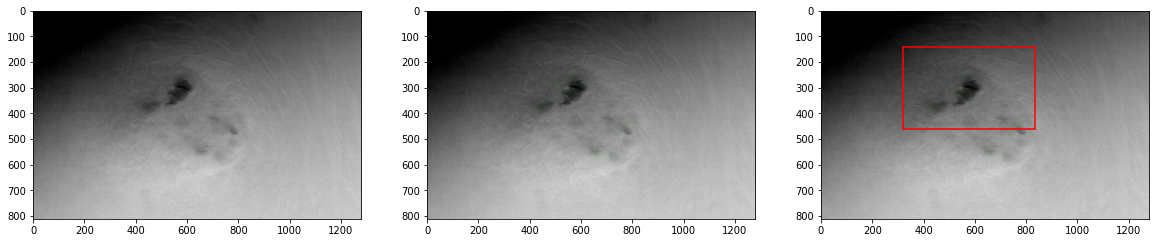

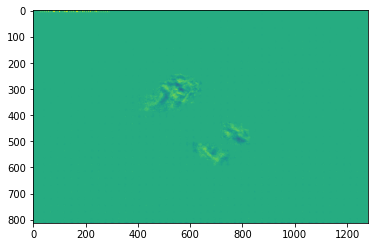

In [70]:
#flow1=(flow_2-flow1)*0.001
fmean=1.3*np.mean(flow_1)
flow_2[flow_1<fmean]=0
#flow1[flow1>fmean]=0.4
img_sa=images[560]
img_sa=Image.fromarray(img_sa).convert('RGB')
img_sa=ImageEnhance.Contrast(img_sa).enhance(7.0)
img_sa=np.array(img_sa)/255.0
display=np.zeros((812,1280,3))
display[:,:,0]=img_sa[:,:,0]
display[:,:,1]=img_sa[:,:,1]+flow1
display[:,:,2]=img_sa[:,:,2]
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(img_sa)
plt.subplot(1,3,2)
plt.imshow(display)
plt.subplot(1,3,3)
plt.imshow(display)
ROI=[300, 576]
plt.plot((576-258,576-258),(300-160,300+160),color='r')
plt.plot((576+258,576+258),(300-160,300+160),color='r')
plt.plot((576-258,576+258),(300-160,300-160),color='r')
plt.plot((576-258,576+258),(300+160,300+160),color='r')
plt.show()
plt.imshow(flow_2)
plt.show()

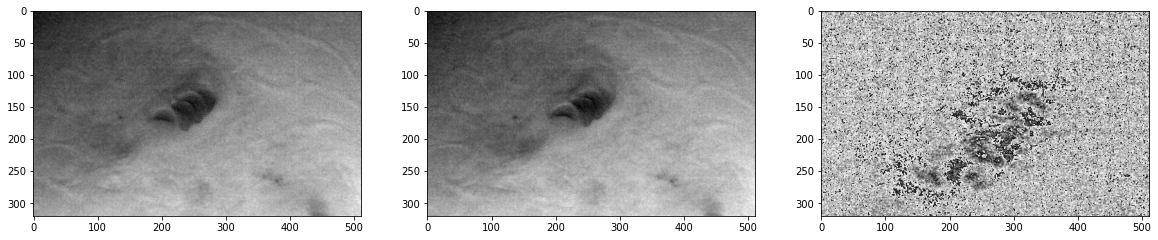

In [30]:
_,img_sample=da[0]
diff=np.zeros_like(img_sample['image'])
for i in range(1,len(da),50):
    _,img=da[i-1]
    _,img1=da[i]
    diff += abs(img['image']-img1['image'])
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(img['image'])
plt.subplot(1,3,2)
plt.imshow(img1['image'])
plt.subplot(1,3,3)
plt.imshow(diff)
#print(np.max(img1['image']),np.min(img1['image']))
#print(np.max(img1['image1']),np.min(img1['image1']))
plt.show()

[ 49  99 149 199 249 299 349 399 449 499 549 599 649 699 749 799 849 899
 949 999]
[41 50 58 52 46 56 50 51 50 40 40 28 33 39 37 28 36 38 29]
[45 63 43 47 51 37 56 38 33 51 26 25 27 22 17 23 19 18 27 24]
[ 45 108 151 198 249 286 342 380 413 464 490 515 542 564 581 604 623 641
 668 692]
20


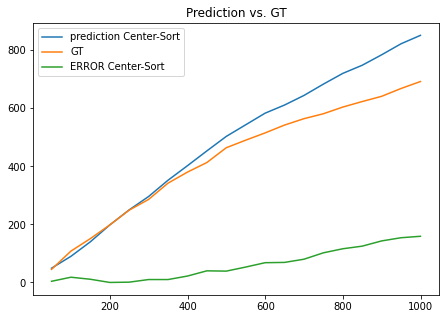

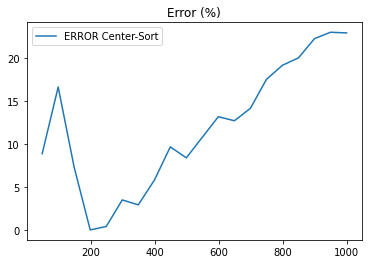

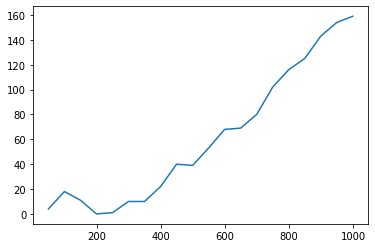

[ 8.88888889 16.66666667  7.28476821  0.          0.40160643  3.4965035
  2.92397661  5.78947368  9.68523002  8.40517241 10.81632653 13.2038835
 12.73062731 14.18439716 17.55593804 19.20529801 20.06420546 22.30889236
 23.05389222 22.97687861]


In [30]:
## file 3
GT=[45,63,43,47,51,37,56,38,33,51,26,25,27,22,17,23,19,18,27,24]
GT1=[0,1,3,2,3,3,1,1,0,3,4,2,3,3,0,2,3,1,3,3]
# file 3_001
#GT=[32,30,29,32,19,39,37,35,47,44,30,38,37,35,43,39,40,54,43,42]
#GT1=[1,1,0,2,1,1,1,3,1,7,1,4,3,1,0,0,1,2,1,0]
#file_4@001
#GT=[66,61,48,49,64,49,48,74,65,81,83,66,88,77,68,89,66,85,78,64]
#GT1=[5,1,5,3,1,0,2,6,1,4,2,1,1,2,1,5,0,5,2,1]
#file_5
#GT=[81,52,39,52,51,42,40,42,44,55,55,0,0,69,62,79,65,67,80,69]
#GT1=[2,4,2,4,4,0,6,1,2,2,1,0,0,5,3,1,1,1,2,1]
# flie_6
#GT=[94,114,101,97,93,85,81,93,81,69,62,52,69,83,42,51,70,54,46,63]
#GT1=[3,1,2,3,4,4,3,3,5,5,6,3,2,2,3,7,5,4,7,1]
#file_6_001
#GT=[61,35,52,43,46,59,54,68,53,70,63,46,61,45,39,48,31,40,67,52]
#GT1=[2,4,1,1,2,3,2,2,3,3,5,2,3,2,1,7,3,2,3,3]
#file_7
#GT=[18,20,18,16,26,21,18,28,28,19,37,31,33,39,35,32,34,28,39,33]
#GT1=[0,2,0,2,1,2,1,0,2,2,0,1,2,2,0,1,0,3,1,2]
#file_7_001
#GT=[0,55,41,41,40,35,46,35,33,42,38,31,49,44,37,51,37,37,36,27,24]
#GT1=[0,0,2,0,2,1,2,1,0,2,2,0,1,2,2,0,1,0,3,1,2]
#file_8
#GT=[33,51,50,29,30,35,30,44,31,45,38,41,56,40,46,39,40,25,35,20]
#GT1=[0,1,2,2,2,0,0,2,4,2,4,0,1,0,1,3,0,1,4,0]
#file_8_001
#GT=[30,23,24,30,22,19,24,20,22,33,32,32,53,50,46,40,41,39,43,36]
#GT1=[1,2,0,2,2,1,4,1,0,3,3,2,4,0,2,2,2,1,0,2]
#file_9
#GT=[45,41,33,50,35,39,47,30,39,42,33,55,50,52,41,39,53,51,40,51]
#GT1=[2,2,1,2,3,2,2,2,0,1,1,2,2,1,3,2,0,0,2,1]
#file_9_001
#GT=[41,45,42,38,48,37,36,47,30,43,61,31,45,39,34,45,36,37,44,40]
#GT1=[2,3,1,3,2,1,2,2,2,1,2,3,2,2,2,1,1,0,1,2]
#file_10
#GT=[59,50,40,56,37,38,53,41,45,56,41,47,57,41,50,51,47,57,41,49]
#GT1=[0,2,1,2,1,1,1,1,1,1,1,0,1,1,1,1,2,0,1,3]
#file_10_001
#GT=[49,52,49,37,47,43,33,45,43,46,65,56,73,70,61,73,62,54,65,51]
#GT1=[1,1,1,0,2,2,0,3,2,0,0,3,1,1,0,0,1,0,0,1]
#GT=GT[5:]
#GT1=GT1[5:]
GT=np.array(GT)#+np.array(GT1)
#GT=GT[:15]
nums=[]
nums1=[]
inds=[]
for ind in range(49,1001,50):
    if ind>=1000:
        ind -= 1
    ids= [k['tracking_id'] for k in results[ind]]
    #ids1= [k['tracking_id'] for k in results1[ind]]
    if len(ids)==0:
        nums.append(nums[-1])
        inds.append(ind)
        continue
    nums.append(max(ids))
    inds.append(ind)
    #nums1.append(max(ids1))
print(np.array(inds))
print(np.diff(nums))
print(np.array(GT))
print(np.cumsum(GT))
plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
plt.title('Prediction vs. GT')
plt.plot(inds,nums)
#plt.plot(inds[1:],nums1[1:])
print(len(inds))
plt.plot(inds,np.cumsum(GT))
ERROR=abs(nums-np.cumsum(GT))
#ERROR1=abs(nums1[1:]-np.cumsum(GT))
plt.plot(inds,ERROR)
#plt.plot(inds[1:],ERROR1)
plt.legend(['prediction Center-Sort','GT','ERROR Center-Sort'])
#plt.legend(['prediction Center-Sort','prediction Center','GT','ERROR Center-Sort'])
plt.show()
plt.title('Error (%)')
plt.plot(inds,ERROR/np.cumsum(GT)*100)
#plt.plot(inds[1:],ERROR1/np.cumsum(GT)*100)
plt.legend(['ERROR Center-Sort','ERROR Center'])
#plt.ylim([0.5,1])
plt.show()

plt.plot(inds,ERROR)
#plt.plot(inds[1:],ERROR1)
#plt.legend(['ERROR w/ age-check','ERROR w/o age-check'])
plt.show()

print(ERROR/np.cumsum(GT)*100)
#plt.plot(abs(np.array(GT)-np.diff(nums))/np.array(GT))
#plt.show()

<Figure size 1152x432 with 0 Axes>

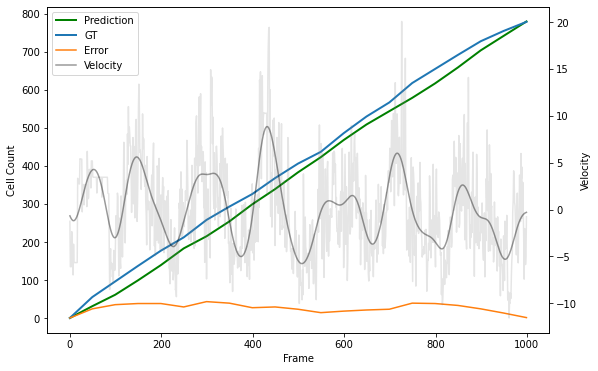

/cis/home/lhuang/anaconda3/envs/CenterTrackENV/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


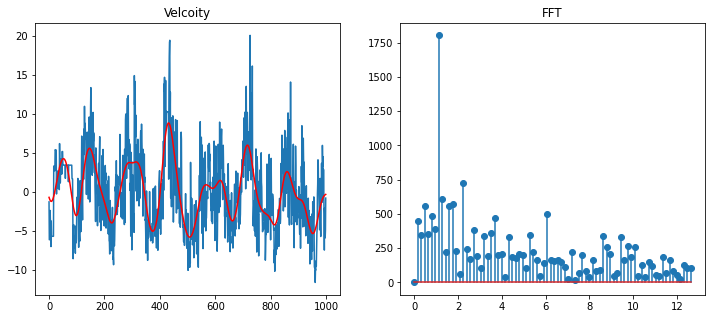

/cis/home/lhuang/anaconda3/envs/CenterTrackENV/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


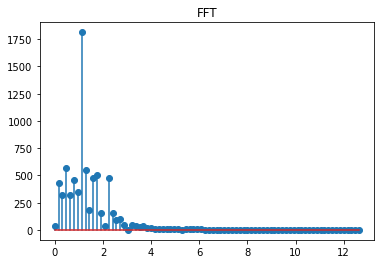

[0, 49, 99, 149, 199, 249, 299, 349, 399, 449, 499, 549, 599, 649, 699, 749, 799, 849, 899, 949, 999]


In [119]:
plt.figure(figsize=(16,6))
#vel=vel[110:]
vel_1=vel-np.mean(vel)
from scipy import fftpack
from scipy import signal
b, a = signal.butter(3, 0.03)
y = signal.filtfilt(b, a, vel_1)
fig, ax1 = plt.subplots(figsize=(9,6))
ax2 = ax1.twinx()
ax1.plot(inds,nums, 'g-',lw=2.,label='Prediction')
ax1.plot(inds,np.cumsum(GT),lw=2.,label='GT')
ax1.plot(inds,ERROR,label='Error')
ax1.set_ylabel('Cell Count')
ax1.set_xlabel('Frame')

ax2.plot(vel_1,'gray',alpha=0.2)
ax2.plot(y,'black',alpha=0.4,label='Velocity')
ax2.set_ylabel('Velocity')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Velcoity')
plt.plot(vel_1)
plt.plot(y,'red')


sp1 = fftpack.fft(vel_1)
freqs = fftpack.fftfreq(len(vel_1)) * 160.0
plt.subplot(1,2,2)
plt.title('FFT')
plt.stem(freqs[:80], np.abs(sp1[:80]))
plt.show()

sp2 = fftpack.fft(y)
freqs2 = fftpack.fftfreq(len(y)) * 160.0
plt.title('FFT')
plt.stem(freqs2[:80], np.abs(sp2[:80]))
plt.show()

print(inds)

[  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850
 900 950 999]
[33 25 25 30 30 39 44 36 31 34 35 37 39 41 46 51 46 47 53 40]
[33 31 29 34 20 40 38 38 48 51 31 42 40 36 43 39 41 56 44 42]
[  0  -6  -4  -4  10  -1   6  -2 -17 -17   4  -5  -1   5   3  12   5  -9
   9  -2]
[3, 36, 61, 86, 116, 146, 185, 229, 265, 296, 330, 365, 402, 441, 482, 528, 579, 625, 672, 725, 765]
[ 33  64  93 127 147 187 225 263 311 362 393 435 475 511 554 593 634 690
 734 776]
20


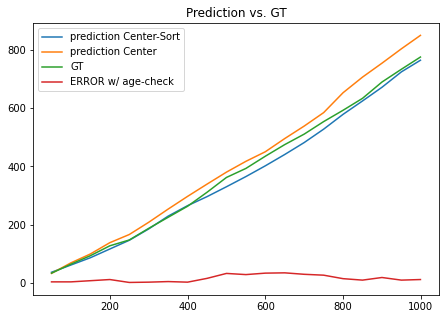

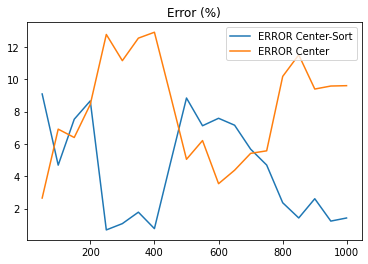

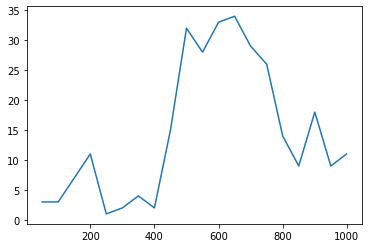

In [16]:
## file 3
#GT=[45,63,43,47,51,37,56,38,33,51,26,25,27,22,17,23,19,18,27,24]
#GT1=[0,1,3,2,3,3,1,1,0,3,4,2,3,3,0,2,3,1,3,3]
#GT=GT[:10]
#GT1=GT1[:10]
## file 3_0001
GT=[32,30,29,32,19,39,37,35,47,44,30,38,37,35,43,39,40,54,43,42]
GT1=[1,1,0,2,1,1,1,3,1,7,1,4,3,1,0,0,1,2,1,0]
GT=GT[:]
GT1=GT1[:]
#GT=[48,49,64,49,48,74,65,81,83,66]
#GT1=[5,3,1,0,2,6,1,4,2,1]
GT=np.array(GT)+np.array(GT1)
nums=[]
nums1=[]
inds=[]
for ind in range(0,1001,50):
    if ind>=1000:
        ind -= 1
    ids= [k['tracking_id'] for k in results[ind]]
    ids1= [k['tracking_id'] for k in results1[ind]]
    if len(ids)==0:
        nums.append(nums[-1])
        inds.append(ind)
        continue
    if len(ids1)==0:
        nums1.append(nums[-1])
        continue
    nums.append(max(ids))
    inds.append(ind)
    nums1.append(max(ids1)*0.825-5)
print(np.array(inds))
print(np.diff(nums))
print(np.array(GT))
print(np.diff(nums)-np.array(GT))
print(nums)
print(np.cumsum(GT))
print(len(nums[1:]))
plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
plt.title('Prediction vs. GT')
plt.plot(inds[1:],nums[1:])
plt.plot(inds[1:],nums1[1:])
plt.plot(inds[1:],np.cumsum(GT))
ERROR=abs(nums[1:]-np.cumsum(GT))
ERROR1=abs(nums1[1:]-np.cumsum(GT))
plt.plot(inds[1:],ERROR)
#plt.plot(inds[1:],ERROR1)
plt.legend(['prediction Center-Sort','prediction Center','GT','ERROR w/ age-check'])
plt.show()
plt.title('Error (%)')
plt.plot(inds[1:],ERROR/np.cumsum(GT)*100)
plt.plot(inds[1:],ERROR1/np.cumsum(GT)*100)
plt.legend(['ERROR Center-Sort','ERROR Center'])
#plt.ylim([0.5,1])
plt.show()

plt.plot(inds[1:],ERROR)
#plt.plot(inds[1:],ERROR1)
#plt.legend(['ERROR w/ age-check','ERROR w/o age-check'])
plt.show()

In [25]:
GT=[32,30,29,32,19,39,37,35,47,44,30,38,37,35,43,39,40,54,43,42,36]
GT1=[1,1,0,2,1,1,1,3,1,7,1,4,3,1,0,0,1,2,1,0,1]
np.sum(GT)+np.sum(GT1)

813

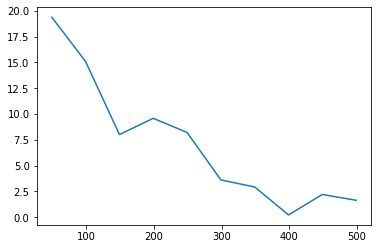

In [43]:
num_4_1=nums
GT_4_1=GT
error_4_1=ERROR
Perror_4_1=ERROR/np.cumsum(GT)*100
plt.plot(inds[1:],ERROR/np.cumsum(GT)*100)

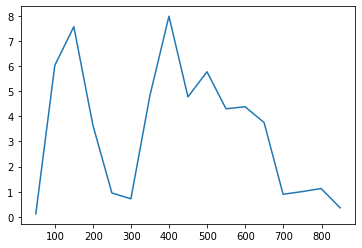

In [25]:
num_3_1=nums
GT_3_1=GT
error_3_1=ERROR
Perror_3_1=ERROR/np.cumsum(GT)*100
plt.plot(inds[1:],ERROR/np.cumsum(GT)*100)

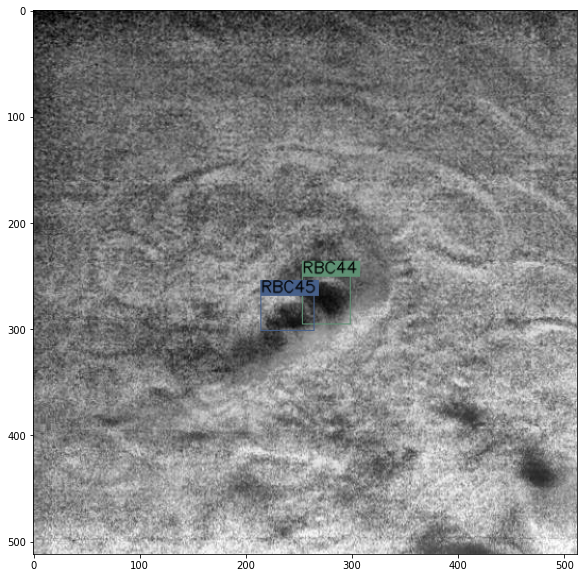

     Frame: 77
     Cell detected in this frame: 2
     Accumulated Cells: 47
[1, 1]


RuntimeError: DataLoader worker (pid(s) 12216) exited unexpectedly

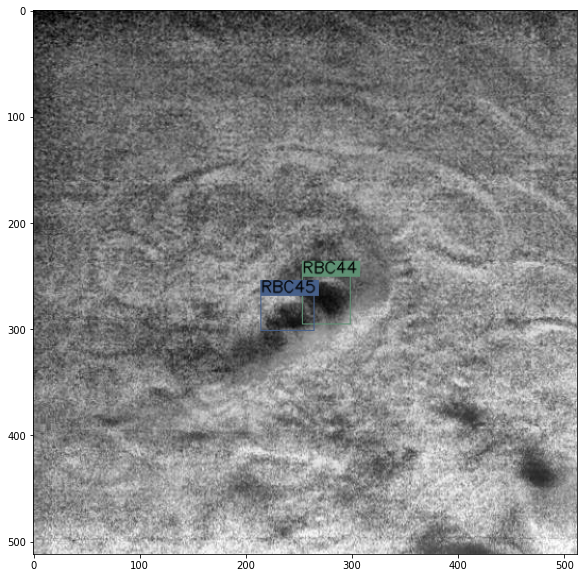

In [6]:
import time
import matplotlib
%matplotlib inline
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.figure(1,figsize=(20,10))
#num_iters = len(data_loader) if opt.num_iters < 0 else opt.num_iters
num_iters=0
num_iters_1=100
acc_num=[]
cell_num=[]
acc_num_GT=[]
cell_num_GT=[]
save_dir=os.path.join(opt.save_dir,'vis_pred')
for ind, (img_id, pre_processed_images) in enumerate(data_loader):
    if ind <= num_iters:
        continue
    if ind >= num_iters_1:
        break  
    bboxes = [k['bbox'] for k in results[ind]]
    classes= [k['class'] for k in results[ind]]
    #bboxes1 = [k['bbox'] for k in results1[ind+1]]
    cell_num.append(len(bboxes))
    #cell_num1.append(len(bboxes1))
    ids= [k['tracking_id'] for k in results[ind]]
    #ids1= [k['tracking_id'] for k in results1[ind+1]]
    img_dir=os.path.join(save_dir,'frame_{}.jpg'.format(ind))
    #img_dir1=os.path.join(save_dir,'frame_{}_1.jpg'.format(ind))
    #draw_bbox(pre_processed_images['image'].numpy()[0,:,:,:],bboxes,ids,img_dir)
    plt.imshow(vis[ind].astype(np.uint16))
    #print(img_dir)
    cv2.imwrite(img_dir,vis[ind])
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
    if len(acc_num) == 0:
        acc_num.append(max(ids))
        #acc_num1.append(max(ids1))
    #elif len(ids)==0 or len(ids1)==0:
    elif len(ids)==0:
        acc_num.append(acc_num[-1])
        #acc_num1.append(acc_num1[-1])
    else:
        acc_num.append(max(max(ids),max(acc_num)))
        #acc_num1.append(max(max(ids1),max(acc_num1)))
    print('     Frame:',ind+1)
    print('     Cell detected in this frame:',len(bboxes))
    print('     Accumulated Cells:',acc_num[-1])
    print(classes)
    time.sleep(1)

In [19]:
from PIL import Image, ImageDraw
vis_gif=[]
for ind in range(500,550):
     vis_gif.append(Image.fromarray(vis[ind]).convert('RGB'))
vis_gif[0].save('/cis/home/lhuang/my_documents/Cytometry/CenterTrack/data/CellTracking/train/Video/save.gif',
               save_all=True, append_images=vis_gif[1:], optimize=False, duration=400, loop=0)

In [ ]:
#### import matplotlib
%matplotlib inline
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.figure(1,figsize=(20,10))
num_iters = len(data_loader) if opt.num_iters < 0 else opt.num_iters
acc_num=[]
cell_num=[]
acc_num1=[]
cell_num1=[]
acc_num_GT=[]
cell_num_GT=[]
dataset1 = Dataset(opt, 'train')
save_dir=os.path.join(opt.save_dir,'vis_pred')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
for ind, (img_id, pre_processed_images) in enumerate(data_loader):
    if ind >= num_iters:
        break
    img, anns, img_info, img_path=dataset._load_data(ind)
    GT_num=len(anns)
    GT_ids= [k['track_id'] for k in anns]
    acc_num_GT.append(max(GT_ids))
    cell_num_GT.append(GT_num)
    bboxes = [k['bbox'] for k in results[ind+1]]
    #bboxes1 = [k['bbox'] for k in results1[ind+1]]
    cell_num.append(len(bboxes))
    #cell_num1.append(len(bboxes1))
    ids= [k['tracking_id'] for k in results[ind+1]]
    #ids1= [k['tracking_id'] for k in results1[ind+1]]
    img_dir=os.path.join(save_dir,'frame_{}.jpg'.format(ind))
    #img_dir1=os.path.join(save_dir,'frame_{}_1.jpg'.format(ind))
    '''
    #draw_bbox(pre_processed_images['image'].numpy()[0,:,:,:],bboxes,ids,img_dir)
    plt.imshow(vis[ind].astype(np.uint16))
    cv2.imwrite(img_dir,vis[ind])
    cv2.imwrite(img_dir1,vis1[ind])
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
    '''
    if len(acc_num) == 0:
        acc_num.append(max(ids))
        #acc_num1.append(max(ids1))
    #elif len(ids)==0 or len(ids1)==0:
    elif len(ids)==0:
        acc_num.append(acc_num[-1])
        #acc_num1.append(acc_num1[-1])
    else:
        acc_num.append(max(max(ids),max(acc_num)))
        #acc_num1.append(max(max(ids1),max(acc_num1)))
    print('     Frame:',ind+1)
    print('     Cell detected in this frame:',len(bboxes),'     GT Cells:',GT_num)
    print('     Accumulated Cells:',acc_num[-1],'     GT Accumulated Cells:',max(GT_ids))

ValueError: operands could not be broadcast together with shapes (20,) (0,) 

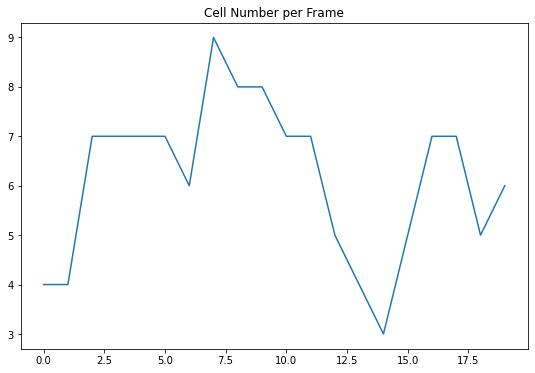

In [9]:
plt.figure(1,figsize=(20,6))
plt.subplot(1,2,1)
plt.title('Cell Number per Frame')
f1=plt.plot(cell_num)
#f1=plt.plot(cell_num1)
f2=plt.plot(cell_num_GT)
cell_error=abs(np.array(cell_num)-np.array(cell_num_GT))
#cell_error_ori=abs(np.array(cell_num1)-np.array(cell_num_GT))
f3=plt.plot(cell_error)
#f3=plt.plot(cell_error_ori)
plt.ylim(0,)
plt.xlim(0,)
plt.legend(['prediction','GT','ERROR'])
#plt.legend(['prediction','pred_ori','GT','ERROR','ERROR_ori'])
plt.subplot(1,2,2)
plt.title('Total Cell Number')
plt.plot(acc_num)
#plt.plot(acc_num1)
plt.plot(acc_num_GT)
acc_error=abs(np.array(acc_num)-np.array(acc_num_GT))
#acc_error_ori=abs(np.array(acc_num1)-np.array(acc_num_GT))
plt.plot(acc_error)
plt.ylim(0,)
plt.xlim(0,)
#plt.plot(acc_error_ori)
#plt.legend(['prediction','pred_ori','GT','ERROR','ERROR_ori'])
plt.legend(['prediction','GT','ERROR'])
plt.show()

In [25]:
opt.tracking_base=False
detector1=Detector(opt)
print(detector1.opt.tracking_base)
opt1=config()
opt1.init()
opt1.tracking_base=True
detector = Detector(opt1)
print(detector.opt.tracking_base)

Creating model...
Using node type: (<class 'model.networks.dla.DeformConv'>, <class 'model.networks.dla.DeformConv'>)
loaded /cis/home/lhuang/my_documents/Cytometry/CenterTrack/exp/tracking/cell_tracking/logs_2020-06-22-02-38/model_232.pth, epoch 232
False
Running tracking
Using tracking threshold for out threshold! 0.5
Fix size testing.
training chunk_sizes: [16]
input h w: 800 1280
heads {'hm': 2, 'reg': 2, 'wh': 2, 'tracking': 2}
weights {'hm': 2.0, 'reg': 1.0, 'wh': 0.4, 'tracking': 1.0}
head conv {'hm': [256], 'reg': [256], 'wh': [256], 'tracking': [256]}
Creating model...
Using node type: (<class 'model.networks.dla.DeformConv'>, <class 'model.networks.dla.DeformConv'>)
loaded /cis/home/lhuang/my_documents/Cytometry/CenterTrack/exp/tracking/cell_tracking/logs_2020-06-22-02-38/model_232.pth, epoch 232
True


In [5]:
###############
## Visualize ##
###############

def draw_bbox(img, bboxes, ids, save_dir,c=(255, 0, 255)):
    for i,bbox in enumerate(bboxes):
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), 
          (int(bbox[2]), int(bbox[3])), 
          c, 2, lineType=cv2.LINE_AA)
        txt = '{}'.format(ids[i])
        cv2.putText(img, txt, (int(bbox[0]), int(bbox[1])), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, 
                    (0, 255, 255), thickness=1, lineType=cv2.LINE_AA)
    plt.imshow(img)
    cv2.imwrite(save_dir,img)
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
    

In [ ]:
def prefetch_test(opt):
    if not opt.not_set_cuda_env:
        os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
    Dataset = dataset_factory[opt.test_dataset]
    #opt = config().update_dataset_info_and_set_heads(opt, Dataset)
    print(opt)
    #Logger(opt)
  
    split = 'val' if not opt.trainval else 'test'
    dataset = Dataset(opt, split)
    detector = Detector(opt)
  
    if opt.load_results != '':
        load_results = json.load(open(opt.load_results, 'r'))
        for img_id in load_results:
            for k in range(len(load_results[img_id])):
                if load_results[img_id][k]['class'] - 1 in opt.ignore_loaded_cats:
                    load_results[img_id][k]['score'] = -1
    else:
        load_results = {}

    data_loader = torch.utils.data.DataLoader(
        PrefetchDataset(opt, dataset, detector.pre_process), 
        batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

    results = {}
    num_iters = len(data_loader) if opt.num_iters < 0 else opt.num_iters
    bar = Bar('{}'.format(opt.exp_id), max=num_iters)
    time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge', 'track']
    avg_time_stats = {t: AverageMeter() for t in time_stats}
    if opt.use_loaded_results:
        for img_id in data_loader.dataset.images:
            results[img_id] = load_results['{}'.format(img_id)]
        num_iters = 0
    for ind, (img_id, pre_processed_images) in enumerate(data_loader):
        plt.imshow(pre_processed_images['image'][0,:,:,:])
        plt.show()
        if ind >= num_iters:
            break
        if opt.tracking and ('is_first_frame' in pre_processed_images):
            if '{}'.format(int(img_id.numpy().astype(np.int32)[0])) in load_results:
                pre_processed_images['meta']['pre_dets'] = \
                  load_results['{}'.format(int(img_id.numpy().astype(np.int32)[0]))]
            else:
                print()
                print('No pre_dets for', int(img_id.numpy().astype(np.int32)[0]), 
                  '. Use empty initialization.')
                pre_processed_images['meta']['pre_dets'] = []
            detector.reset_tracking()
            print('Start tracking video', int(pre_processed_images['video_id']))
        if opt.public_det:
            if '{}'.format(int(img_id.numpy().astype(np.int32)[0])) in load_results:
                pre_processed_images['meta']['cur_dets'] = \
                  load_results['{}'.format(int(img_id.numpy().astype(np.int32)[0]))]
            else:
                print('No cur_dets for', int(img_id.numpy().astype(np.int32)[0]))
                pre_processed_images['meta']['cur_dets'] = []
        ret = detector.run(pre_processed_images)
        results[int(img_id.numpy().astype(np.int32)[0])] = ret['results']
        print(results)
        Bar.suffix = '[{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(
                       ind, num_iters, total=bar.elapsed_td, eta=bar.eta_td)
        for t in avg_time_stats:
            avg_time_stats[t].update(ret[t])
            Bar.suffix = Bar.suffix + '|{} {tm.val:.3f}s ({tm.avg:.3f}s) '.format(
                t, tm = avg_time_stats[t])
        if opt.print_iter > 0:
            if ind % opt.print_iter == 0:
                print('{}/{}| {}'.format(opt.task, opt.exp_id, Bar.suffix))
        else:
              bar.next()
    bar.finish()
    if opt.save_results:
        print('saving results to', opt.save_dir + '/save_results_{}{}.json'.format(
          opt.test_dataset, opt.dataset_version))
        json.dump(_to_list(copy.deepcopy(results)), 
                  open(opt.save_dir + '/save_results_{}{}.json'.format(
                    opt.test_dataset, opt.dataset_version), 'w'))
    dataset.run_eval(results, opt.save_dir)

def test(opt):
    os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str

    Dataset = dataset_factory[opt.test_dataset]
    #opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
    print(opt)
    Logger(opt)

    split = 'val' if not opt.trainval else 'test'
    dataset = Dataset(opt, split)
    detector = Detector(opt)

    if opt.load_results != '': # load results in json
        load_results = json.load(open(opt.load_results, 'r'))

    results = {}
    num_iters = len(dataset) if opt.num_iters < 0 else opt.num_iters
    bar = Bar('{}'.format(opt.exp_id), max=num_iters)
    time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge']
    avg_time_stats = {t: AverageMeter() for t in time_stats}
    for ind in range(num_iters):
        img_id = dataset.images[ind]
        img_info = dataset.coco.loadImgs(ids=[img_id])[0]
        img_path = os.path.join(dataset.img_dir, img_info['file_name'])
        input_meta = {}
        if 'calib' in img_info:
            input_meta['calib'] = img_info['calib']
        if (opt.tracking and ('frame_id' in img_info) and img_info['frame_id'] == 1):
            detector.reset_tracking()
            input_meta['pre_dets'] = load_results[img_id]

        ret = detector.run(img_path, input_meta)  
        results[img_id] = ret['results']

        Bar.suffix = '[{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(
                       ind, num_iters, total=bar.elapsed_td, eta=bar.eta_td)
        for t in avg_time_stats:
            avg_time_stats[t].update(ret[t])
            Bar.suffix = Bar.suffix + '|{} {:.3f} '.format(t, avg_time_stats[t].avg)
        bar.next()
    bar.finish()
    if opt.save_results:
        print('saving results to', opt.save_dir + '/save_results_{}{}.json'.format(
          opt.test_dataset, opt.dataset_version))
        json.dump(_to_list(copy.deepcopy(results)), 
                  open(opt.save_dir + '/save_results_{}{}.json'.format(
                    opt.test_dataset, opt.dataset_version), 'w'))
    dataset.run_eval(results, opt.save_dir)


def _to_list(results):
    for img_id in results:
        for t in range(len(results[img_id])):
            for k in results[img_id][t]:
                if isinstance(results[img_id][t][k], (np.ndarray, np.float32)):
                    results[img_id][t][k] = results[img_id][t][k].tolist()
    return results

In [31]:
!pip install libtiff

Processing /cis/home/lhuang/.cache/pip/wheels/7c/ce/79/9c7115224f798f73bdbd2c23e06c6fa048adcca7041b9fd104/libtiff-0.4.2-cp36-cp36m-linux_x86_64.whl


In [3]:
class PrefetchDataset(torch.utils.data.Dataset):
    def __init__(self, opt, dataset, pre_process_func):
        self.images = dataset.images
        self.load_image_func = dataset.coco.loadImgs
        self.load_mask = dataset._load_data
        self.img_dir = dataset.img_dir
        self.ann_dir=self.img_dir.replace('image','cellLabel.xlsx')
        self.mask_dir=self.img_dir.replace('image','mask')
        self.init_mask()
        self.mask_shape=(812, 1280 ,3)
        self.pre_process_func = pre_process_func
        self.get_default_calib = dataset.get_default_calib
        self.opt = opt
  
    def get_rand_color(self):
        c = ((np.random.random((3)) * 0.6 + 0.2) * 255).astype(np.int32).tolist()
        return c
    
    def __getitem__(self, index):
        img_id = self.images[index]
        img_info = self.load_image_func(ids=[img_id])[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        masks=self.masks[index]
        img_mask=np.zeros(shape=self.mask_shape)
        for mask in masks:
            c=self.get_rand_color()
            mask_path=os.path.join(self.mask_dir, mask)+'.tif'
            mask_loaded=TIFF.open(mask_path).read_image()
            mask_loaded[mask_loaded>0]=1
            img_mask[:,:,0]+= mask_loaded*c[0]
            img_mask[:,:,1]+= mask_loaded*c[1]
            img_mask[:,:,2]+= mask_loaded*c[2]
        img_mask /= np.max(img_mask)
        img_mask *= 255.0
        img = cv2.imread(img_path).astype(np.float16)
        img -= np.min(img)
        img /= np.max(img)
        img=Image.fromarray(np.uint8(img*255.0)).convert('RGB')
        img.save('s.jpg')
        image = cv2.imread('s.jpg')
        images, meta = {}, {}
        for scale in opt.test_scales:
            input_meta = {}
            calib = img_info['calib'] if 'calib' in img_info \
            else self.get_default_calib(image.shape[1], image.shape[0])
            input_meta['calib'] = calib
            images[scale], meta[scale] = self.pre_process_func(image, scale, input_meta)
        ret = {'images': images, 'image': image, 'meta': meta,'mask':img_mask}
        if 'frame_id' in img_info and img_info['frame_id'] == 1:
            ret['is_first_frame'] = 1
            ret['video_id'] = img_info['video_id']
        return img_id, ret
    
    def init_mask(self):
        ann=xlrd.open_workbook(self.ann_dir).sheets()[0]
        frames=ann.col_values(1,1)
        MaskName=ann.col_values(4,1)
        self.masks=[]
        for image_id in self.images:
            masks = [MaskName[i] for i,frame in enumerate(frames) if frame==image_id]
            self.masks.append(masks)
    def __len__(self):
        return len(self.images)
def _to_list(results):
    for img_id in results:
        for t in range(len(results[img_id])):
            for k in results[img_id][t]:
                if isinstance(results[img_id][t][k], (np.ndarray, np.float32)):
                    results[img_id][t][k] = results[img_id][t][k].tolist()
    return results

In [9]:
aa=np.array([[1.0,2.0],[2.0,3.],[3.,4.]])
bb=np.array([[-1.0,2.0],[1.,3.]])
dist=((aa.reshape(1, -1, 2) - aa.reshape(-1, 1, 2)) ** 2).sum(axis=2)
print(dist)
print(np.median(dist,axis=1))
#np.dot(aa,bb)/(np.sqrt(sum(aa**2))*np.sqrt(sum(bb**2)))

[[0. 2. 8.]
 [2. 0. 2.]
 [8. 2. 0.]]
[2. 2. 2.]


In [32]:
video_dir=os.path.join(opt.data_dir,'CellTracking','train','video')
video_file=os.listdir(video_dir)[0]
video_path=os.path.join(video_dir,video_file)
images=TIFF.open(video_path)
n=0
for image in images.iter_images():
    n += 1
    print(n)
#plt.imshow(images)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


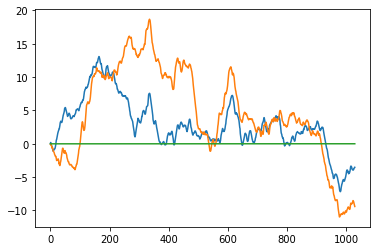

In [53]:
def move_estimate_video(video):
    n_frame=len(video)
    transforms = np.zeros((n_frame-1, 3), np.float32)
    prev_gray = np.float32(video[0])
    prev_gray -= np.min(prev_gray)
    prev_gray /= np.max(prev_gray)
    prev_gray = np.uint8(prev_gray*255)
    h,w=prev_gray.shape
    video_out=np.zeros((n_frame,h,w))
    video_out[0]=prev_gray
    for i in range(1,n_frame):
        prev_pts = cv2.goodFeaturesToTrack(prev_gray[-500:,:500],
                                         maxCorners=200,
                                         qualityLevel=0.01,
                                         minDistance=50,
                                         blockSize=40)
        #curr_gray = np.hstack([video[i][:,:75],video[i][:,-75:]])
        curr_gray = np.float32(video[i])
        curr_gray -= np.min(curr_gray)
        curr_gray /= np.max(curr_gray)
        curr_gray = np.uint8(curr_gray*255)
        video_out[i]=curr_gray
        curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray[-500:,:500], curr_gray[-500:,:500], prev_pts, None)
        
        # Sanity check
        assert prev_pts.shape == curr_pts.shape
        
        # Filter only valid points
        idx = np.where(status==1)[0]
        prev_pts = prev_pts[idx]
        curr_pts = curr_pts[idx]

        #Find transformation matrix
        m,inliers = cv2.estimateAffinePartial2D(prev_pts, curr_pts)
        # Extract translation
        dx = m[0,2]
        dy = m[1,2]

        # Extract rotation angle
        da = np.arctan2(m[1,0], m[0,0])

        # Store transformation
        transforms[i-1] = [dx,dy,da]

        # Move to next frame
        prev_gray = curr_gray
    return transforms,video_out

def fixBorder(frame):
    s = frame.shape
    # Scale the image 4% without moving the center
    T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.04)
    frame = cv2.warpAffine(frame, T, (s[1], s[0]))
    return frame

def stabilize_video(transforms, video):
    n_frames=len(video)
    h,w = video[0].shape
    # Reset stream to first frame
    frames_out=np.zeros([n_frames,h,w])
    # Write n_frames-1 transformed frames
    for i in range(n_frames-1):
        # Read next frame
        frame = video[i+1]
        # Extract transformations from the new transformation array
        dx = transforms[i,0]
        dy = transforms[i,1]
        da = transforms[i,2]
        # Reconstruct transformation matrix accordingly to new values
        m = np.zeros((2,3), np.float32)
        m[0,0] = np.cos(da)
        m[0,1] = -np.sin(da)
        m[1,0] = np.sin(da)
        m[1,1] = np.cos(da)
        m[0,2] = dx
        m[1,2] = dy
        # Apply affine wrapping to the given frame
        frame_stabilized = cv2.warpAffine(frame, m, (w,h))
        # Fix border artifacts
        frame_stabilized = fixBorder(frame_stabilized)
        frames_out[i] = frame_stabilized
    return frames_out

transforms,video=move_estimate_video(da.images)
trajectory = np.cumsum(transforms, axis=0)
transforms_smooth = transforms-trajectory
stable_video=stabilize_video(transforms_smooth,video)
plt.plot(trajectory[:,0])
plt.plot(trajectory[:,1])
plt.plot(trajectory[:,2])
plt.show()
diff=np.zeros_like(stable_video[0])
for i in range(1,len(da.images),50):
    diff += np.abs(stable_video[i]-stable_video[i-1])

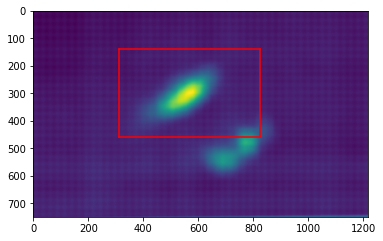

selected region:  300 568


In [60]:
from scipy import signal
kernel1=np.ones((64,64))
conved=signal.convolve2d(diff, kernel1, 'valid')
plt.imshow(conved)
x,y=np.unravel_index(np.argmax(conved, axis=None), conved.shape)
plt.plot((y+512/2,y+512/2),(x-320/2,x+320/2),'r')
plt.plot((y-512/2,y-512/2),(x-320/2,x+320/2),'r')
plt.plot((y-512/2,y+512/2),(x-320/2,x-320/2),'r')
plt.plot((y-512/2,y+512/2),(x+320/2,x+320/2),'r')
plt.show()
print('selected region: ',x,y)

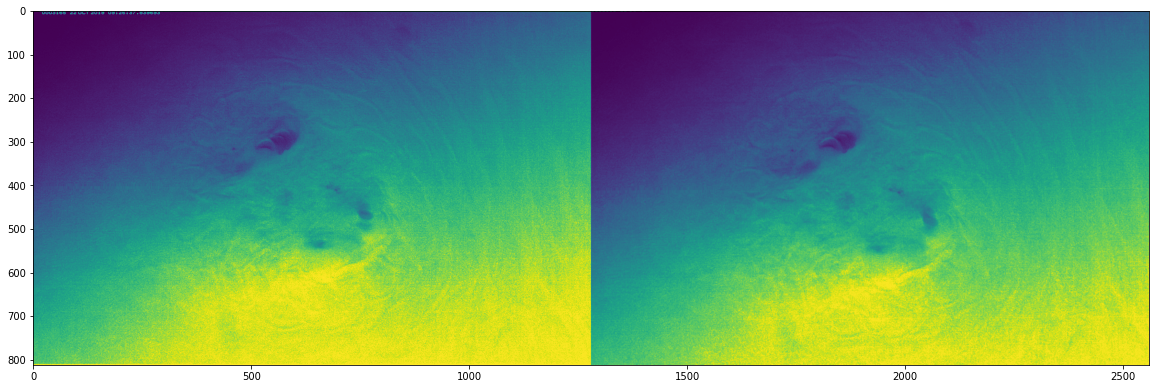

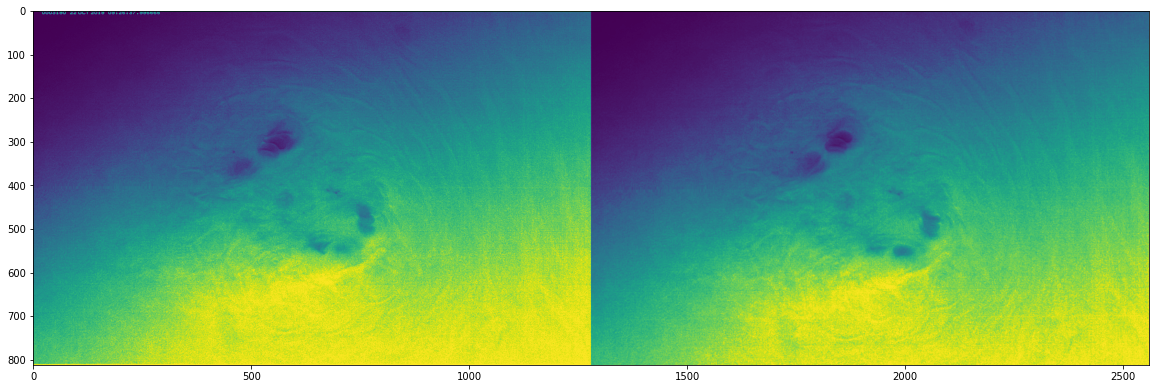

In [57]:
import matplotlib
%matplotlib inline
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
plt.figure(figsize=(20,10))
if is_ipython:
    from IPython import display
plt.ion()
for i in range(1,len(da.images),25):
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
    frame_out = cv2.hconcat([video[i], stable_video[i]])
    frame_out = np.uint8(frame_out)
    plt.imshow(cv2.equalizeHist(frame_out))
plt.show()

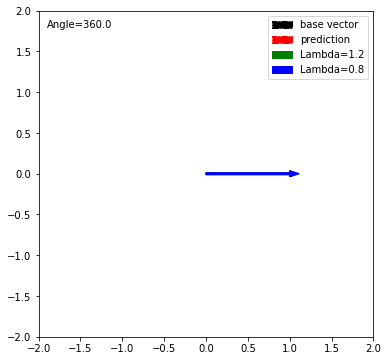

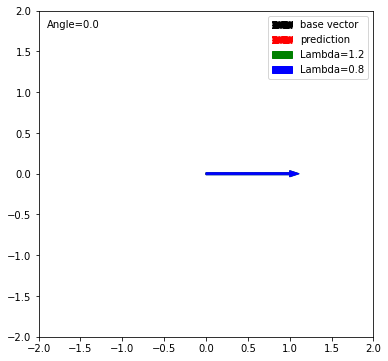

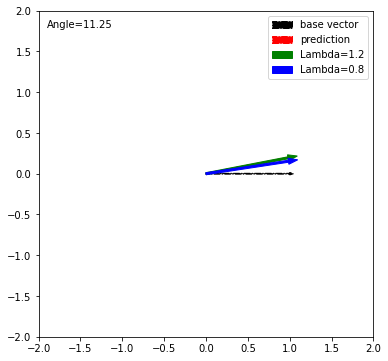

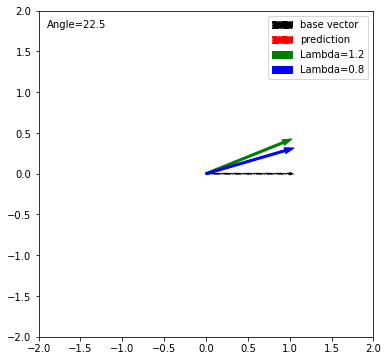

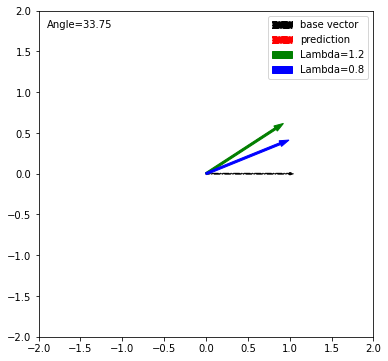

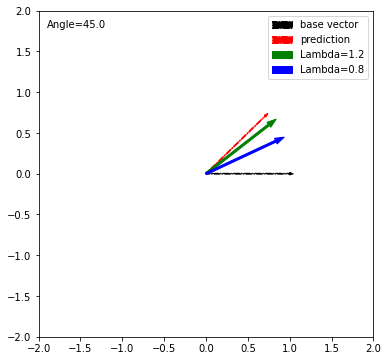

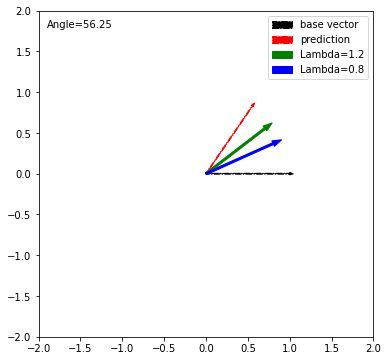

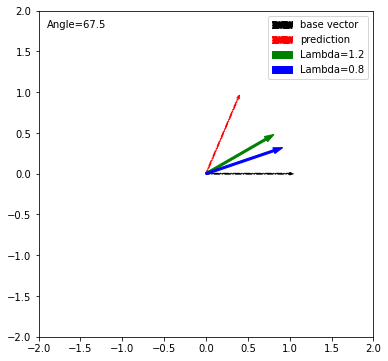

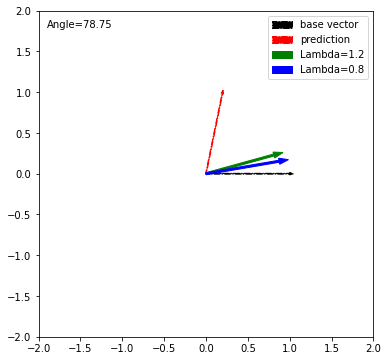

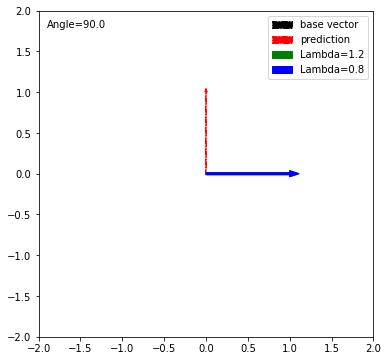

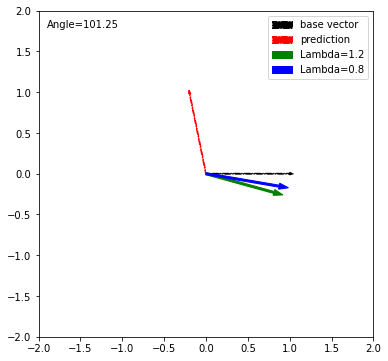

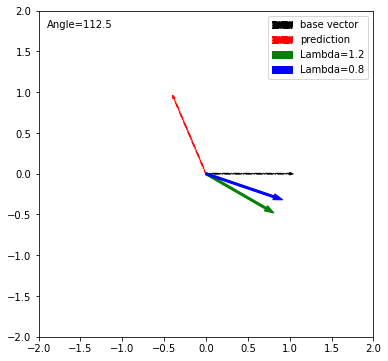

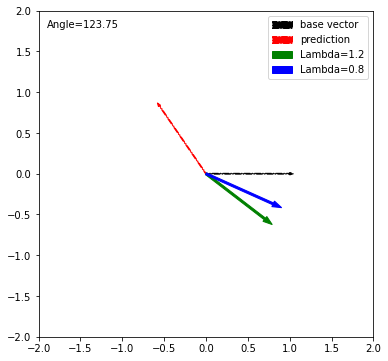

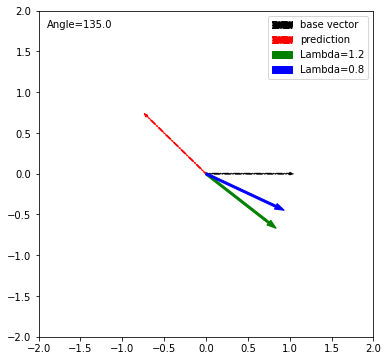

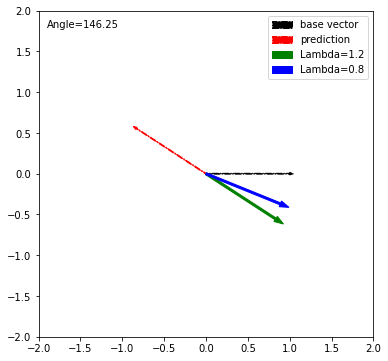

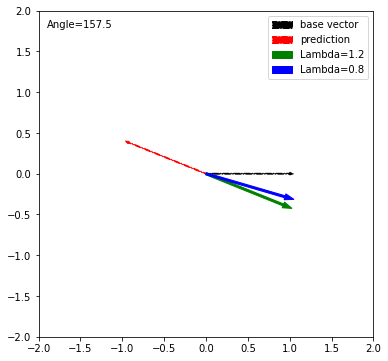

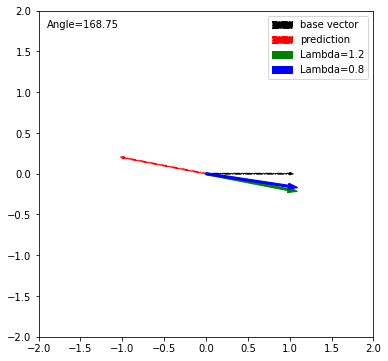

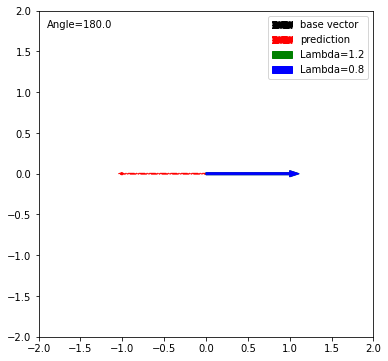

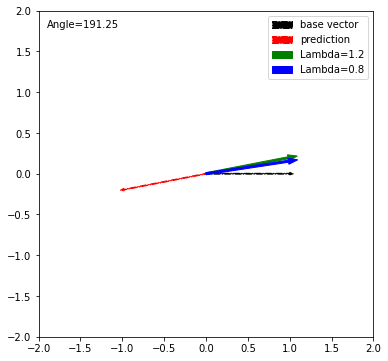

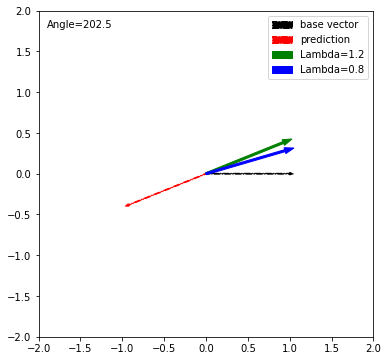

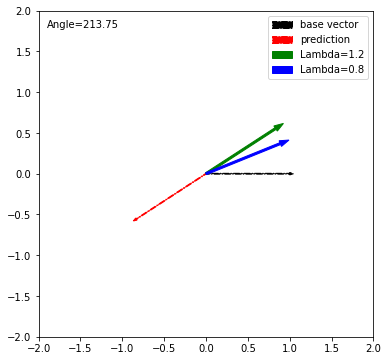

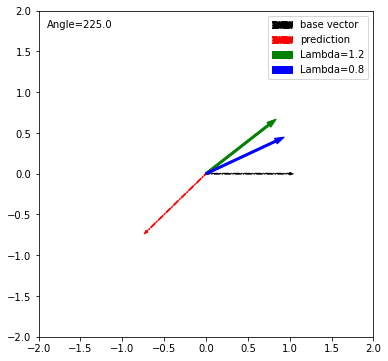

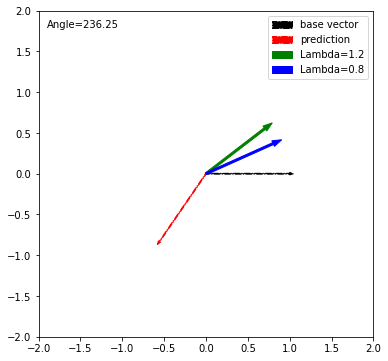

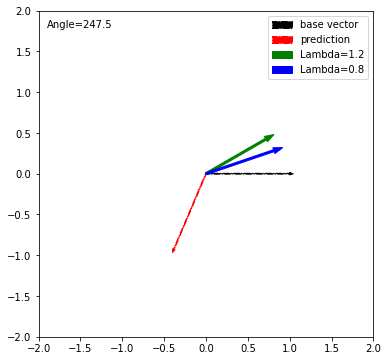

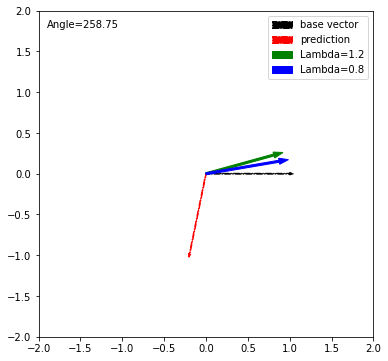

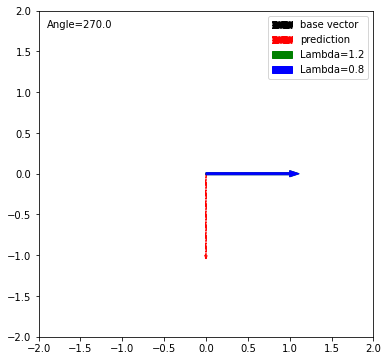

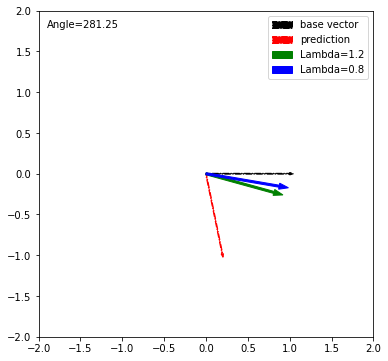

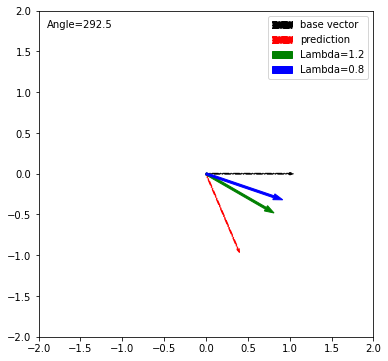

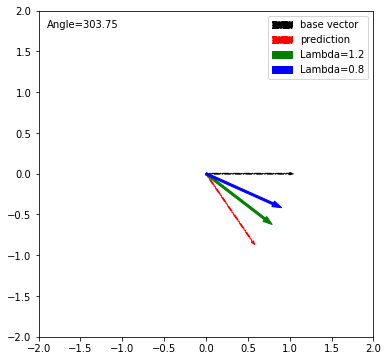

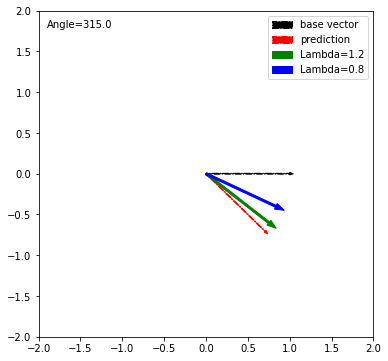

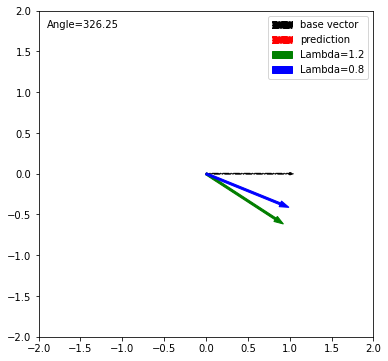

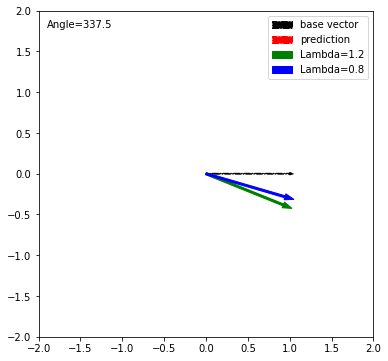

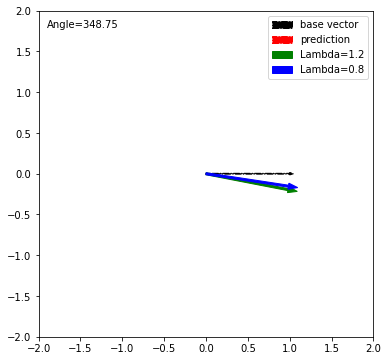

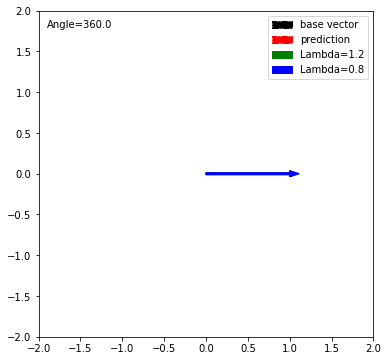

In [35]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import matplotlib
from PIL import Image
%matplotlib inline
from PIL import Image, ImageDraw
vis_gif=[]
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
Pi=3.1415926
base = np.array([1,0])
step=16
thetas=np.arange(0,2*step+1)/step
lamb1 = 1.2
lamb2 = 0.8
for theta in thetas:
    pred = np.array([math.cos(theta*Pi),math.sin(theta*Pi)])
    corr1 = np.max([np.min([lamb1*np.dot(pred,base),1]),-1])*pred + np.max([(1-lamb1*abs(np.dot(pred,base))),0])*base
    corr2 = np.max([np.min([lamb2*np.dot(pred,base),1]),-1])*pred + np.max([(1-lamb2*abs(np.dot(pred,base))),0])*base
    fig=plt.figure(figsize=(6,6))
    plt.xlim(-2.0, 2.0)
    plt.ylim(-2.0, 2.0)
    plt.text(-1.9,1.8,'Angle={}'.format(theta*180))
    pbase=plt.arrow(0,0,base[0],base[1],width=0.01,color='black',ls='-.')
    ppred=plt.arrow(0,0,pred[0],pred[1],width=0.01,color='r',ls='-.')
    pcorr1=plt.arrow(0,0,corr1[0],corr1[1],width=0.025,color='green')
    pcorr2=plt.arrow(0,0,corr2[0],corr2[1],width=0.025,color='blue')
    plt.legend((pbase,ppred,pcorr1,pcorr2),('base vector','prediction','Lambda={}'.format(lamb1),'Lambda={}'.format(lamb2)))
    plt.savefig('corr_demo.png')
    vis_gif.append(Image.open('corr_demo.png'))
    #plt.show()
    # Wait for 5 seconds
    time.sleep(0.5)
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
vis_gif[0].save('/cis/home/lhuang/my_documents/Cytometry/CenterTrack/data/CellTracking/train/Video/corr_demo.gif',save_all=True, append_images=vis_gif[1:], optimize=False, duration=400, loop=0)

In [21]:
import numpy as np
from numpy import float32 as float32
a=np.ones((4,))
print(np.hstack([a,1]))

[1. 1. 1. 1. 1.]
